## Planteamiento del problema

### Contexto empresarial

Las fuentes de energía renovables juegan un papel cada vez más importante en la combinación energética global, a medida que aumenta el esfuerzo por reducir el impacto ambiental de la producción de energía.

De todas las alternativas de energía renovable, la energía eólica es una de las tecnologías más desarrolladas a nivel mundial. El Departamento de Energía de EE. UU. ha elaborado una guía para lograr la eficiencia operativa mediante prácticas de mantenimiento predictivo.

El mantenimiento predictivo utiliza información de sensores y métodos de análisis para medir y predecir la degradación y la capacidad futura de los componentes. La idea detrás del mantenimiento predictivo es que los patrones de falla son predecibles y si la falla del componente se puede predecir con precisión y el componente se reemplaza antes de que falle, los costos de operación y mantenimiento serán mucho más bajos.

Los sensores instalados en diferentes máquinas involucradas en el proceso de generación de energía recopilan datos relacionados con varios factores ambientales (temperatura, humedad, velocidad del viento, etc.) y características adicionales relacionadas con varias partes de la turbina eólica (caja de cambios, torre, palas, rotura , etc.).



## Objetivo
“ReneWind” es una empresa que trabaja en la mejora de la maquinaria/procesos involucrados en la producción de energía eólica utilizando el aprendizaje automático y ha recopilado datos de fallas del generador de turbinas eólicas utilizando sensores. Han compartido una versión cifrada de los datos, ya que los datos recopilados a través de sensores son confidenciales (el tipo de datos recopilados varía según las empresas). Los datos tienen 40 predictores, 20000 observaciones en el conjunto de entrenamiento y 5000 en el conjunto de prueba.

El objetivo es construir varios modelos de clasificación, ajustarlos y encontrar el mejor que ayude a identificar fallas para que los generadores puedan repararse antes de fallar para reducir el costo general de mantenimiento.
La naturaleza de las predicciones hechas por el modelo de clasificación se traducirá de la siguiente manera:

- Los verdaderos positivos (TP) son fallas correctamente predichas por el modelo. Esto resultará en costos de reparación.
- Los falsos negativos (FN) son fallos reales donde no hay detección por parte del modelo. Esto resultará en costos de reemplazo.
- Los falsos positivos (FP) son detecciones donde no hay falla. Esto resultará en costos de inspección.

Se da que el costo de reparar un generador es mucho menor que el costo de reemplazarlo, y el costo de inspección es menor que el costo de reparación.

"1" en las variables objetivo debe considerarse como "falla" y "0" representa "Sin falla".

## Datos Descripción
- Los datos proporcionados son una versión transformada de los datos originales que se recopilaron mediante sensores.
- Train.csv: se utilizará para entrenar y ajustar modelos.
- Test.csv: solo para probar el rendimiento del mejor modelo final.
- Ambos conjuntos de datos constan de 40 variables predictoras y 1 variable objetivo

## Importación de bibliotecas necesarias

In [1]:
# Librerías para la manipulación de datos
import pandas as pd
import numpy as np

# Librerías para la visualización de datos
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Metrica de los modelos
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
)
from sklearn import metrics

# Dividir el conjunto de entrenamiento y de prueba, como tambien para la vali
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Escalar y la codificación oneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Imputar valores faltantes
from sklearn.impute import SimpleImputer

# Manejar el conjunto de datos desbalanceado
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Busqueda aleatoria de mejores parametros
from sklearn.model_selection import RandomizedSearchCV

# Funciones para crear y manejar pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Visualizar el máximo número de columnas y máximo número de filas
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Suprimir notaciones cientificas
pd.set_option("display.float_format", lambda x: "%.3f" % x)


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

## Cargando el conjunto de datos

In [2]:
data = pd.read_csv("./data/train.csv")
print(data.shape)
data_test = pd.read_csv("./data/Test.csv")
print(data_test.shape)

(20000, 41)
(5000, 41)


* Evidentemente tenemos 20000 datos de entrenamiento y 5000 datos de prueba

## Resumen de datos

- Observaciones
- Controles de cordura

In [3]:
data.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


* Los valores presentan valores negativos, pero en el archivo indica que si se puede llevar ello dado a que las columnas poseen nombres insignificantes para proteger la integridad de los datos

In [4]:
data.columns.values

array(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29',
       'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38',
       'V39', 'V40', 'Target'], dtype=object)

* No existe problemas con el nombre de las columnas

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

* Observamos  columnas con valores tipo floar(decimal) a excepción del target de tipo entero

### Análisis de target

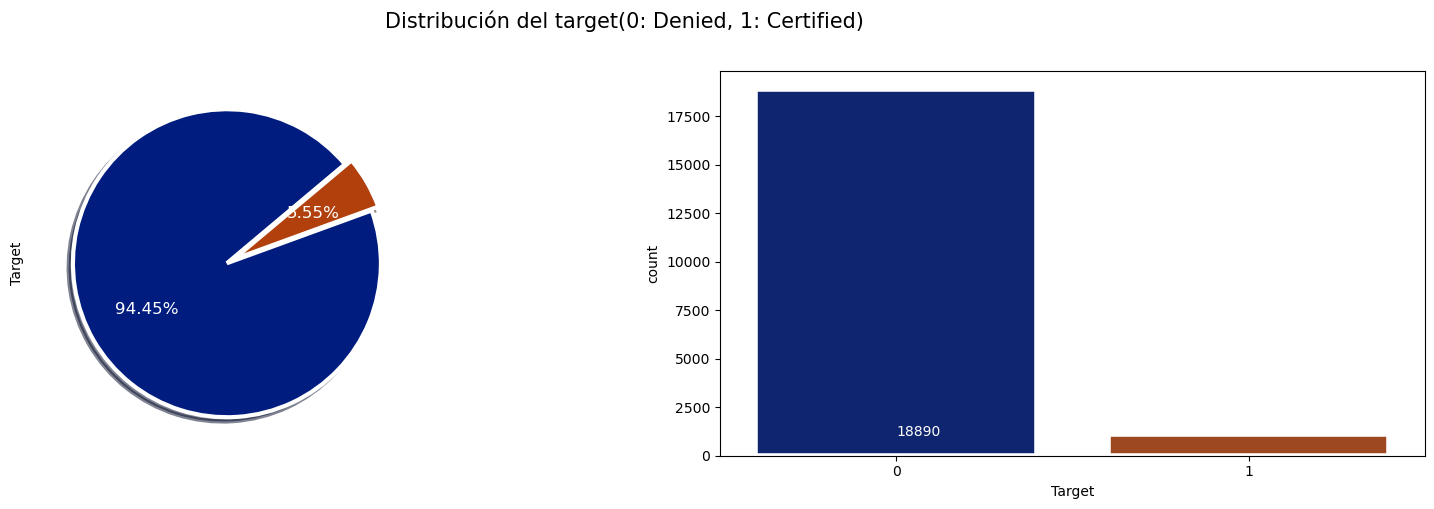

In [6]:
f,ax= plt.subplots(1,2,figsize=(20,5))
sns.countplot(data = data, x=data.Target, ax=ax[1],palette='dark',edgecolor='white', linewidth=4)
data.Target.value_counts().plot.pie(autopct='%.2f%%',explode=[0,0.05], ax=ax[0],colors=sns.color_palette('dark'),shadow = 'True',
        startangle = 40,
        textprops = {'color': 'White','fontsize':12},
        wedgeprops = {'linewidth':3,'edgecolor':'white'},
        rotatelabels = 'true')
ax[1].text(x=0,y=1000,s=data.Target.value_counts()[0], color='white')
ax[1].text(x=1,y=2500,s=data.Target.value_counts()[1], color='white', va='center', ha='center')
f.suptitle('Distribución del target(0: Denied, 1: Certified)',y=0.98,ha='center',va='center',size=15, weight=150)
plt.show()

* Se puede notar una distribución demasiado desbalanceada y ello se puede tratar con:
* Aumento de datos a la clase con menor distrubución
* Disminución de datos a la clase con mayor distribución
* Aumento de el peso a la variable con menor distribución

### Análisis Estadístico

In [7]:
# Resumen estadistico

univariate = data.describe().transpose()
univariate.reset_index(inplace=True)  # quito los indices
univariate.rename(
    columns={
        "index": "feature",  # cambio los nombres
        "25%": "Q1",
        "50%": "median",
        "75%": "Q3",
    },
    inplace=True,
)
univariate

,feature,count,mean,std,min,Q1,median,Q3,max
0,V1,19982.000,-0.272,3.442,-11.876,-2.737,-0.748,1.840,15.493
1,V2,19982.000,0.440,3.151,-12.320,-1.641,0.472,2.544,13.089
2,V3,20000.000,2.485,3.389,-10.708,0.207,2.256,4.566,17.091
3,V4,20000.000,-0.083,3.432,-15.082,-2.348,-0.135,2.131,13.236
4,V5,20000.000,-0.054,2.105,-8.603,-1.536,-0.102,1.340,8.134
5,V6,20000.000,-0.995,2.041,-10.227,-2.347,-1.001,0.380,6.976
6,V7,20000.000,-0.879,1.762,-7.950,-2.031,-0.917,0.224,8.006
7,V8,20000.000,-0.548,3.296,-15.658,-2.643,-0.389,1.723,11.679
8,V9,20000.000,-0.017,2.161,-8.596,-1.495,-0.068,1.409,8.138
9,V10,20000.000,-0.013,2.193,-9.854,-1.411,0.101,1.477,8.108


In [8]:
# Analisis de duplicados
duplicados = data.duplicated().sum()
duplicados

0

* No hay valores duplicados

---

## Análisis exploratorio de datos (EDA)

### Análisis univariado

In [9]:
def plot_boxplot_histogram(data, feature, figsize=(10, 8), kde=True, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(   # Se crean dos subplots, uno para boxplot y otro para el histograma
        nrows=2,
        sharex=True,  # comparten el eje x
        gridspec_kw={"height_ratios": (0.25, 0.75)}, # tamaño de los gráficos
        figsize=figsize,
    )  
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="#2ecc71"  #showmeans indica que se mostrará la media
    )  
    
    if (data[feature].dtype == 'int64'):
        sns.histplot(data=data, x=feature, ax=ax_hist2)
        ax_hist2.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
    if (data[feature].dtype == 'float64'):
        sns.histplot(data=data, x=feature, ax=ax_hist2)
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Agrega ka nedia de la variable feature
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Agrega la mediana de la variable feature
    ax_box2.set_title(f"Boxplot e Histograma de {feature}", 
                      fontdict = {'fontsize': 15})
    plt.show()

In [10]:
# selección de variables categóricas y numericas
df_categoricas = data.select_dtypes(include=['object']).columns.to_list()
df_numericas = data.select_dtypes(include=['float64', 'int64']).columns.to_list()
print("\033[1m" + 'Variables categoricas' + "\033[0m\n", df_categoricas)
print("\033[1m" + 'Variables numericas' + "\033[0m\n", df_numericas)

Variables categoricas
 []
Variables numericas
 ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'Target']


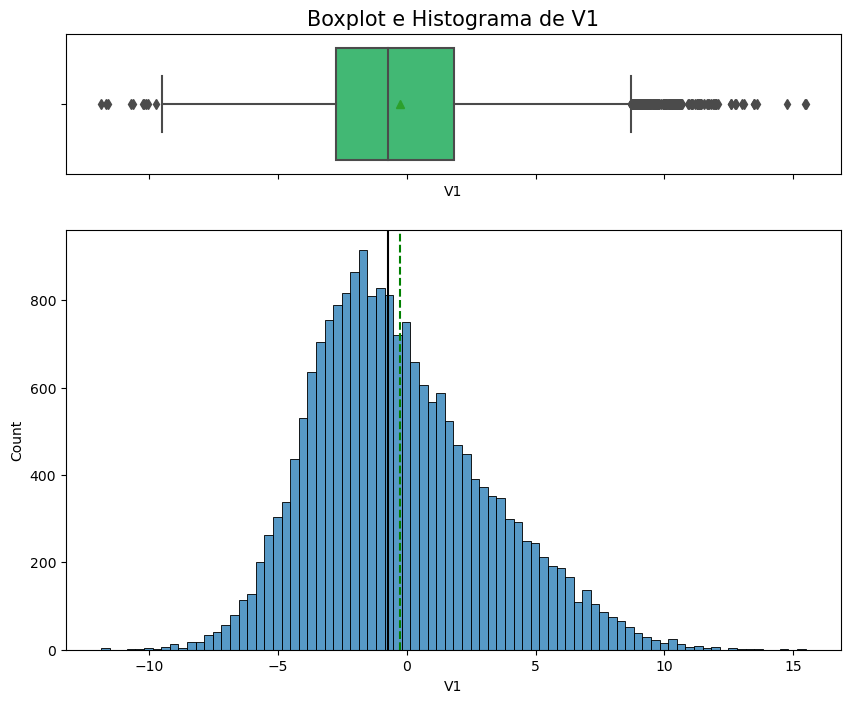

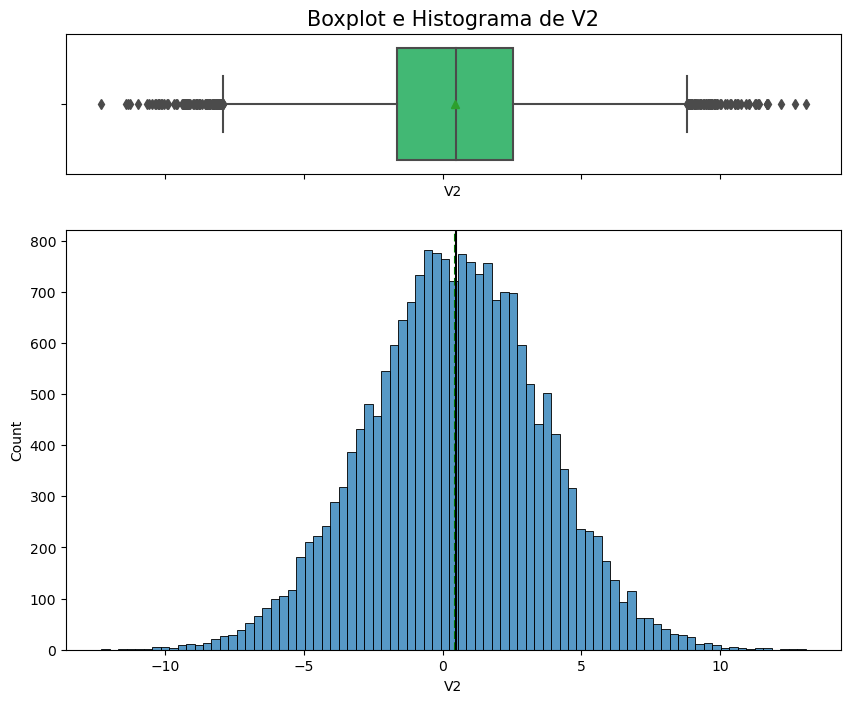

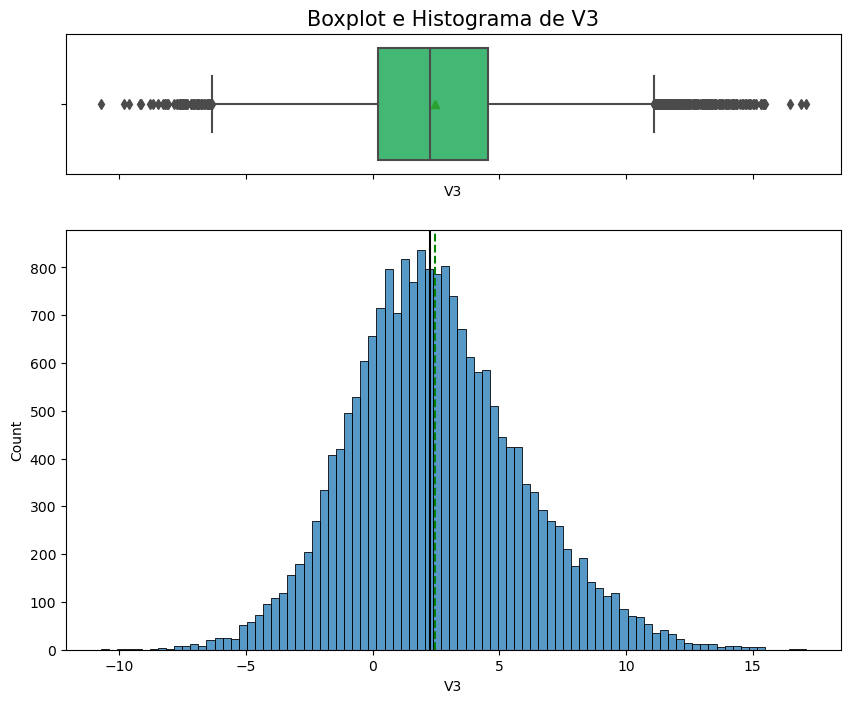

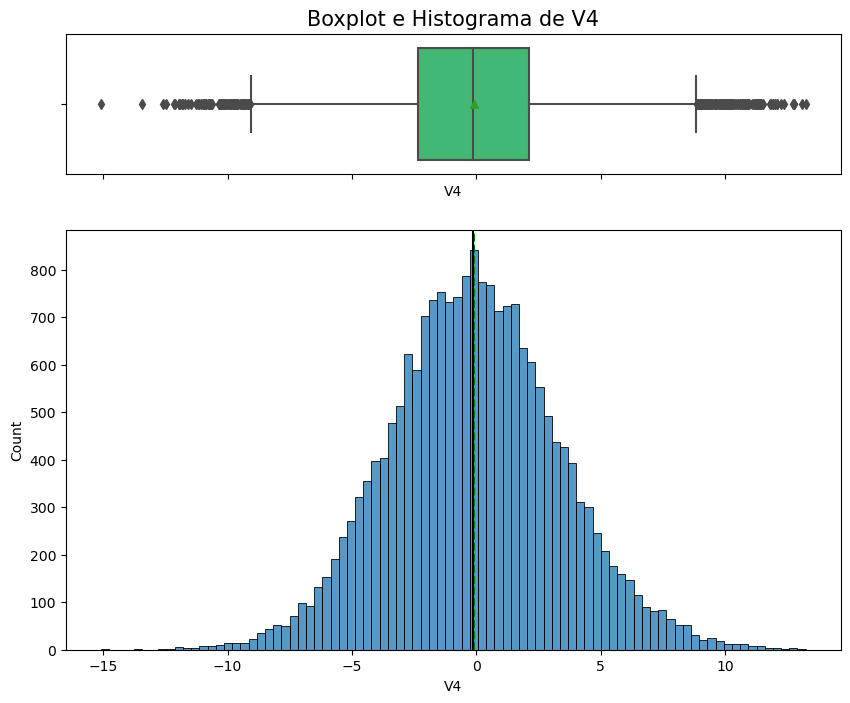

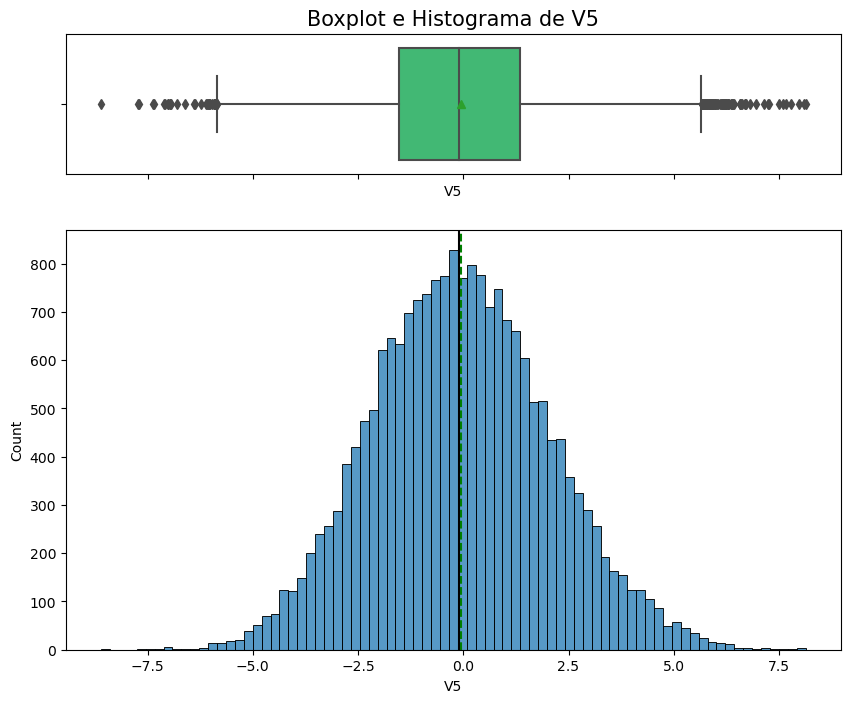

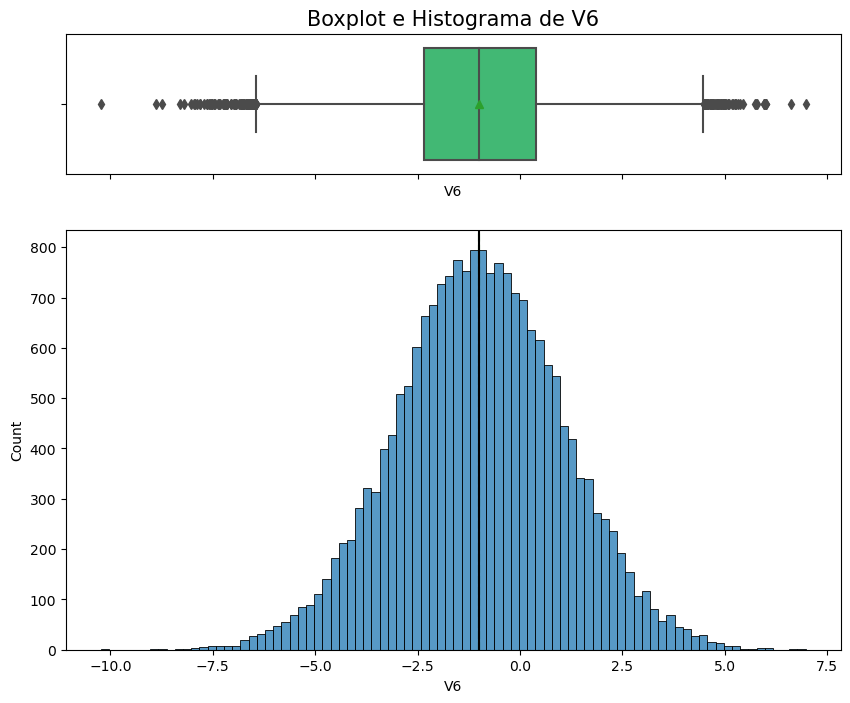

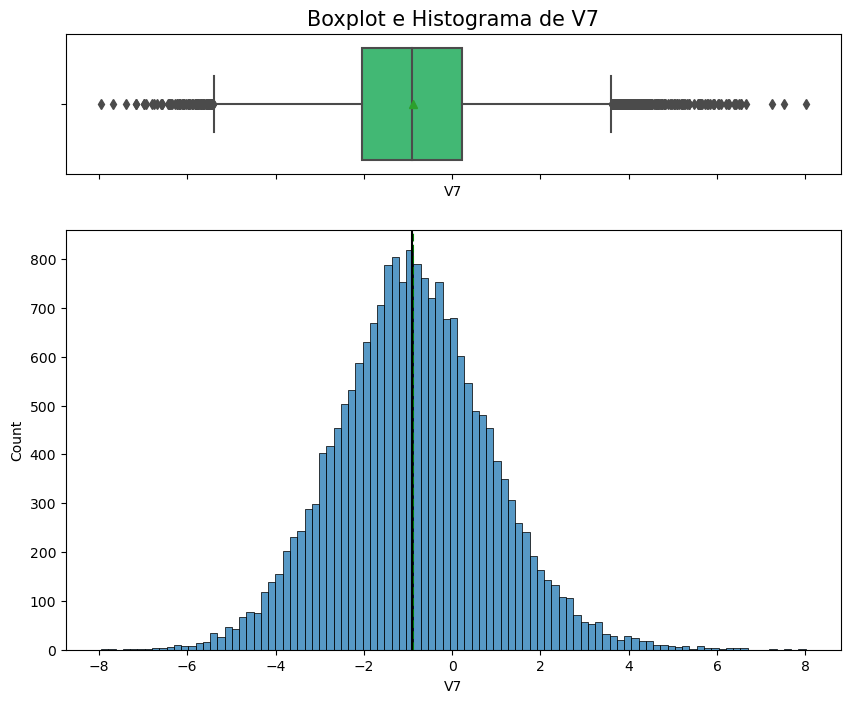

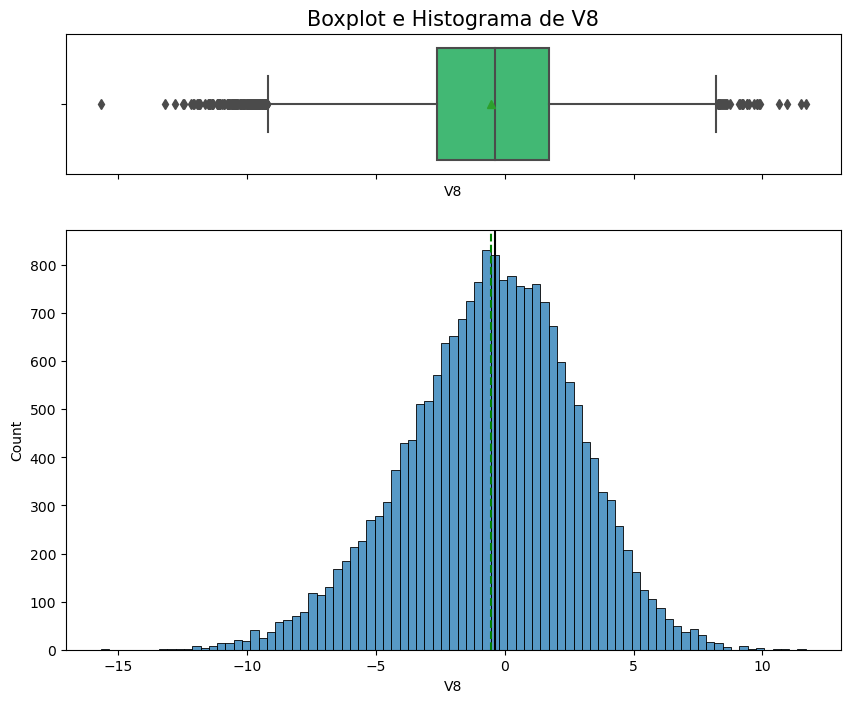

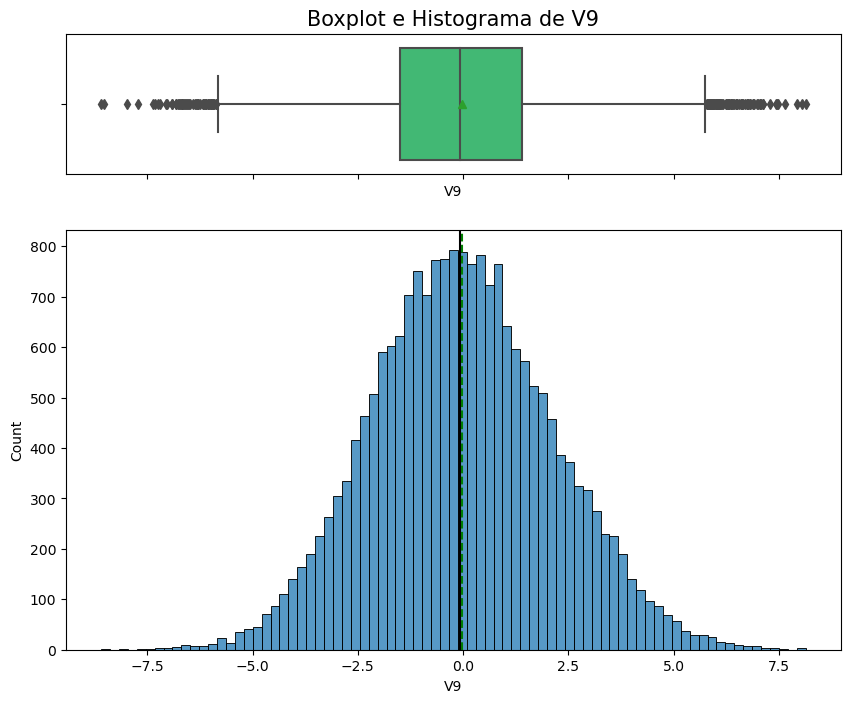

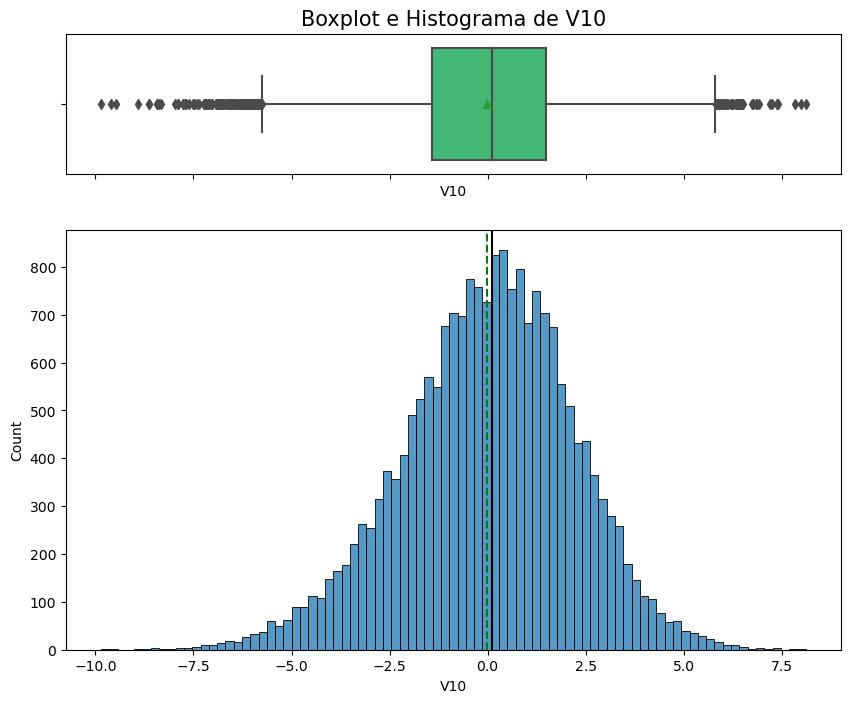

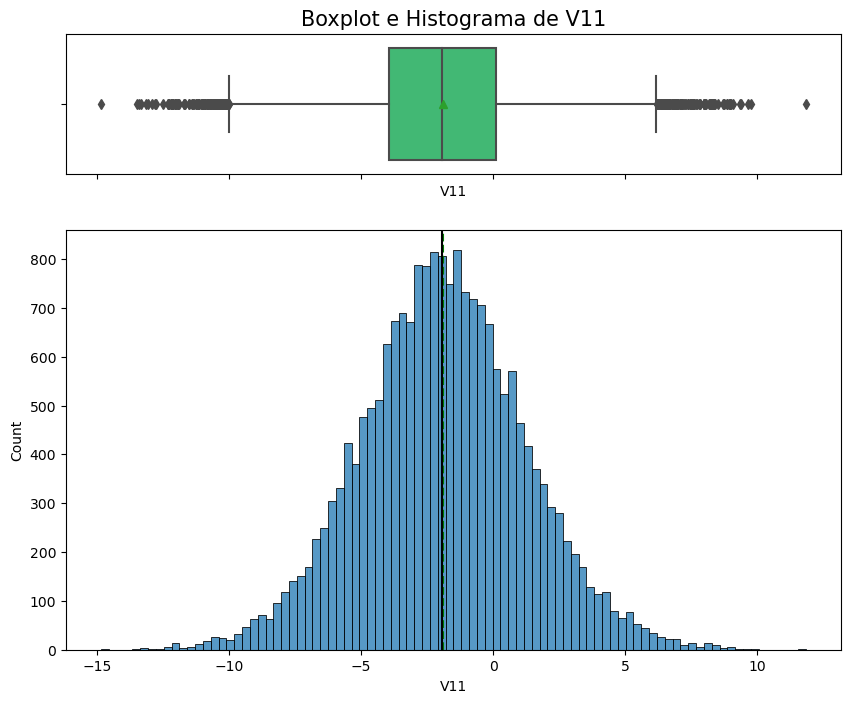

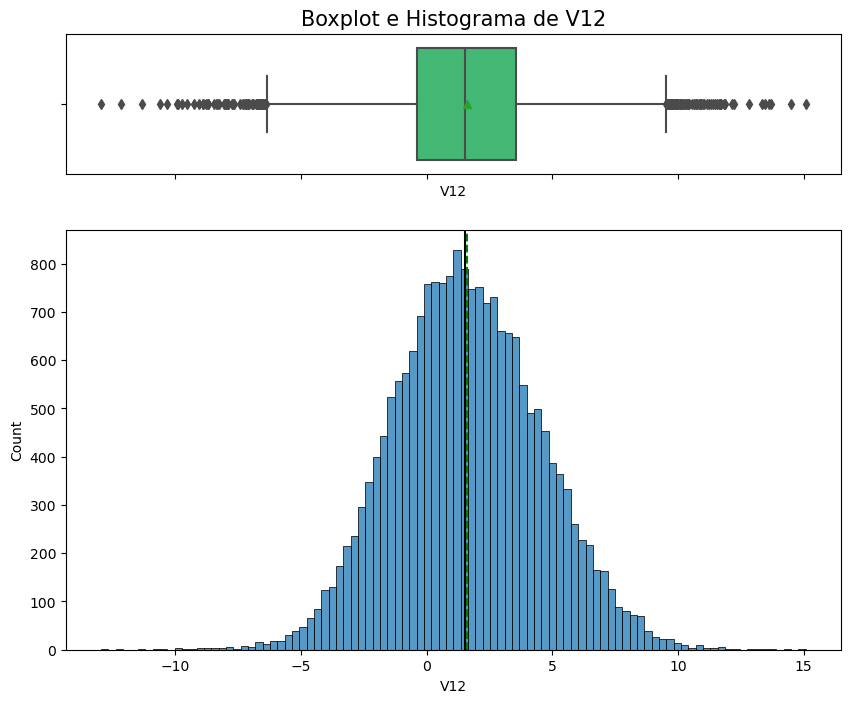

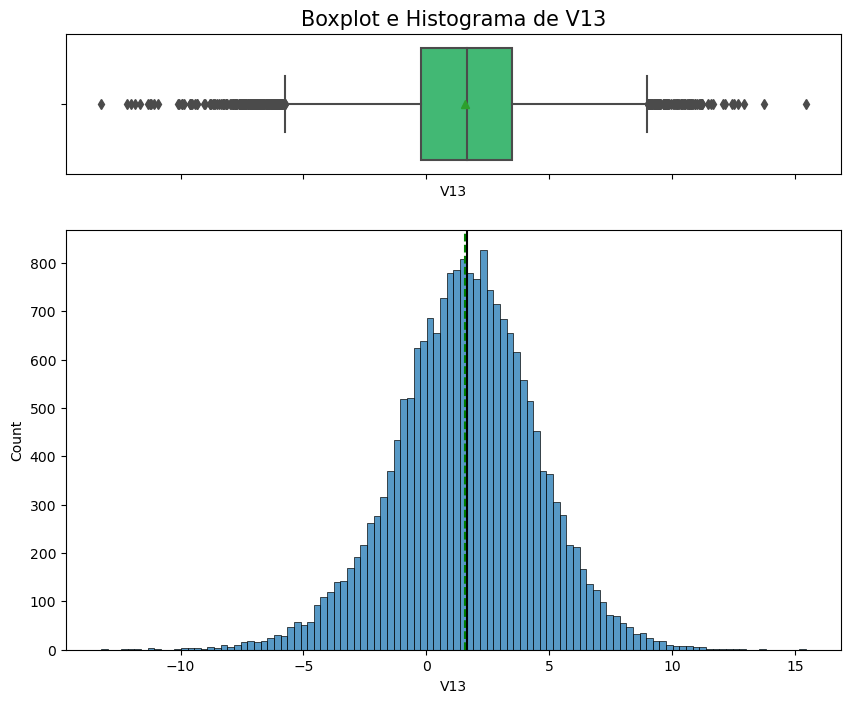

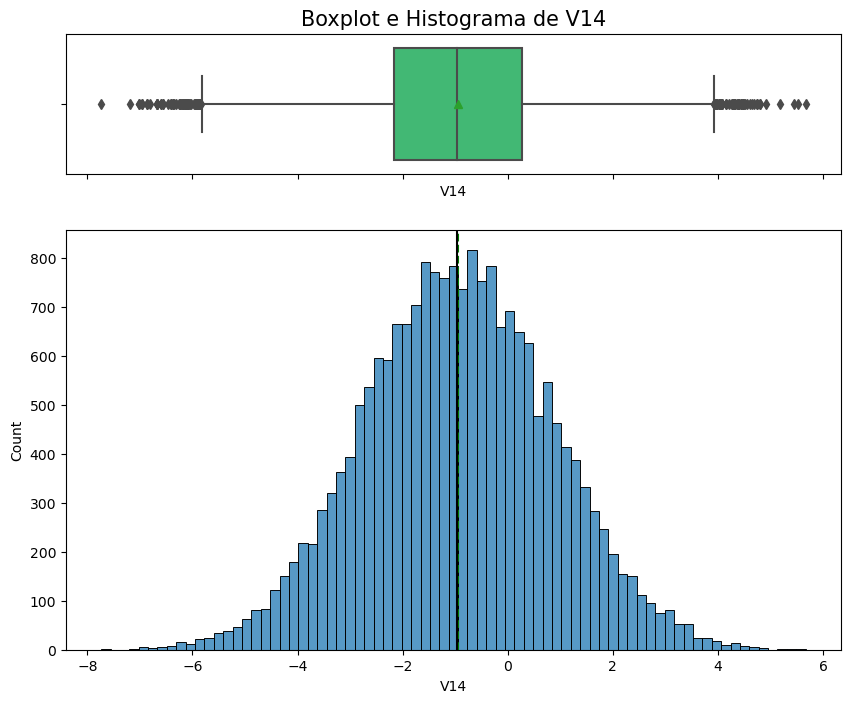

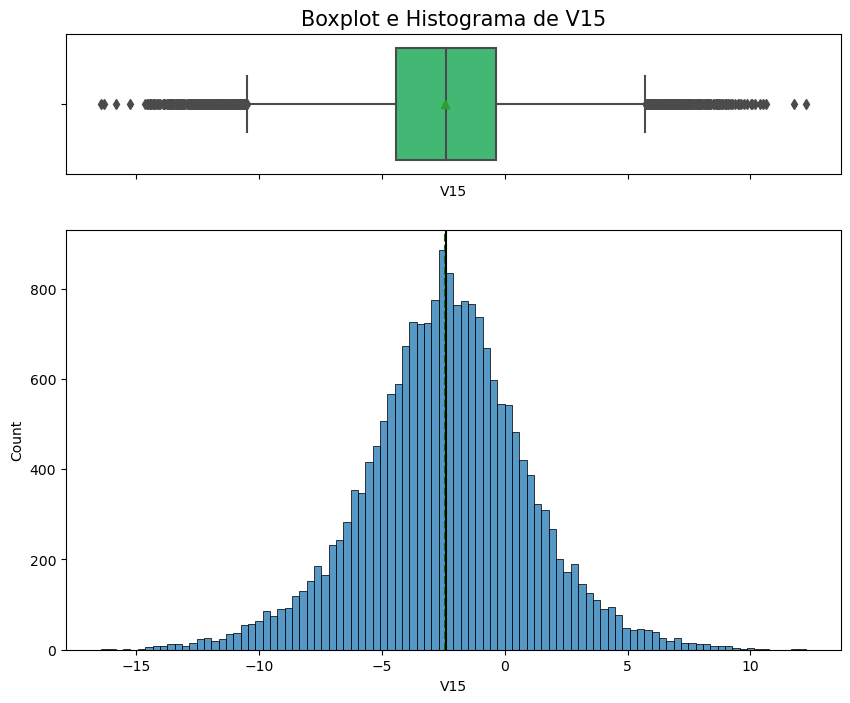

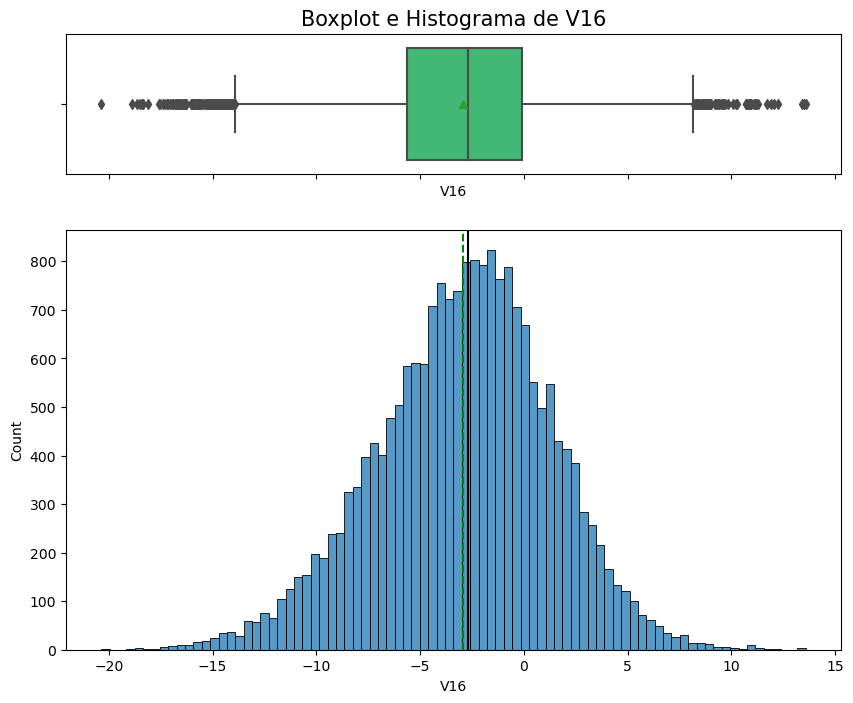

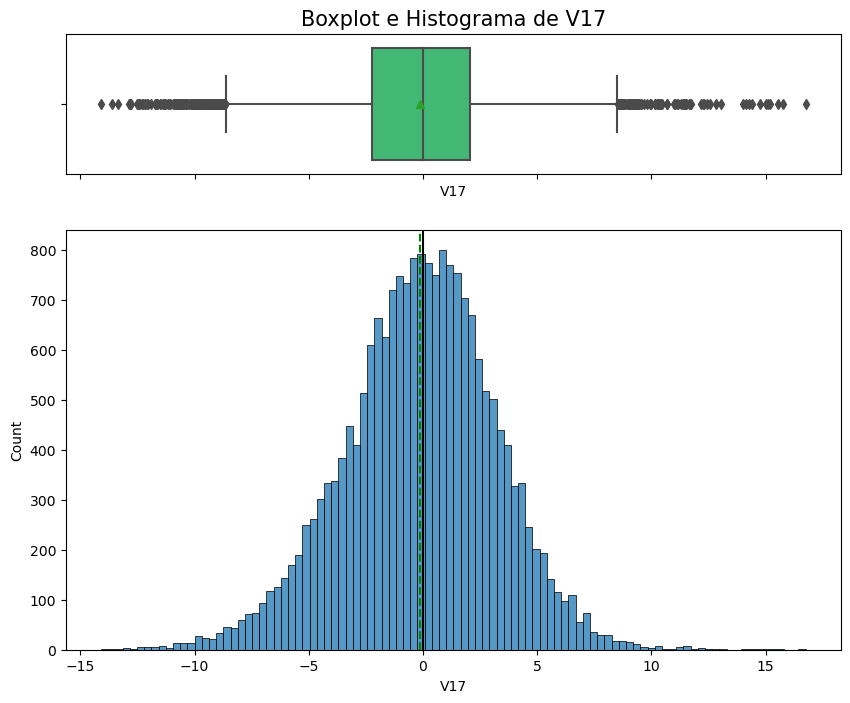

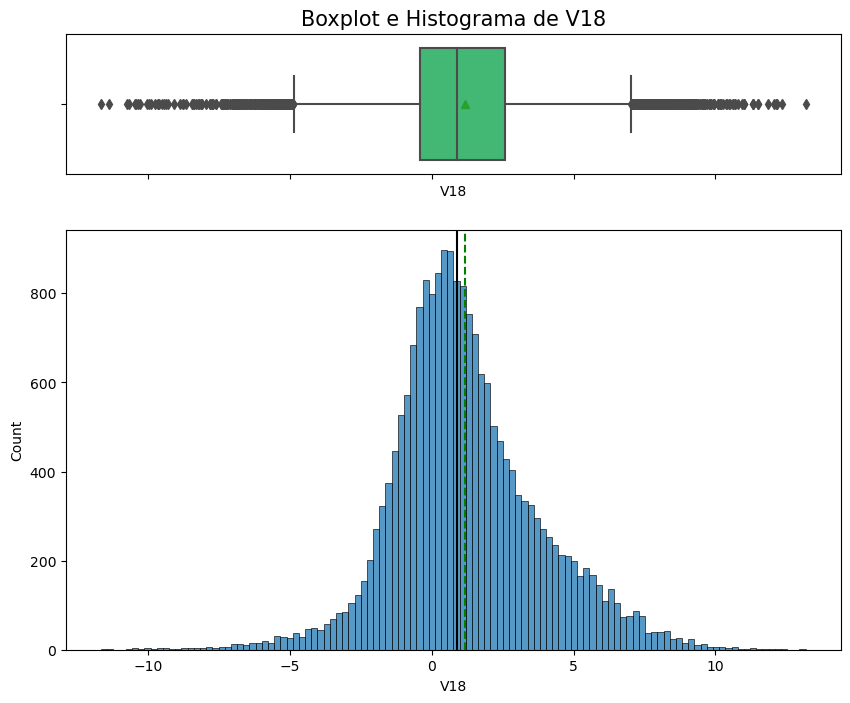

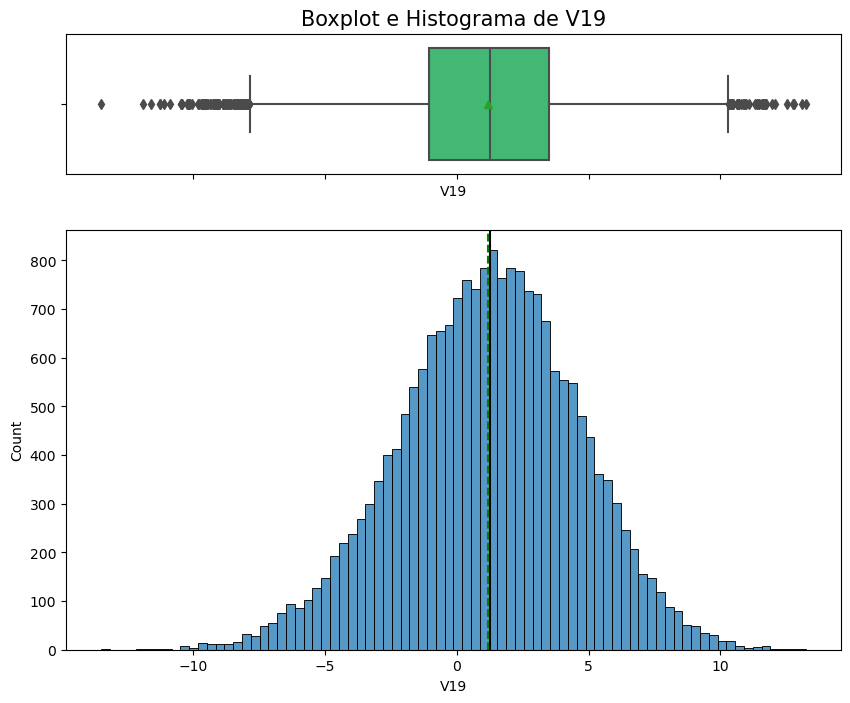

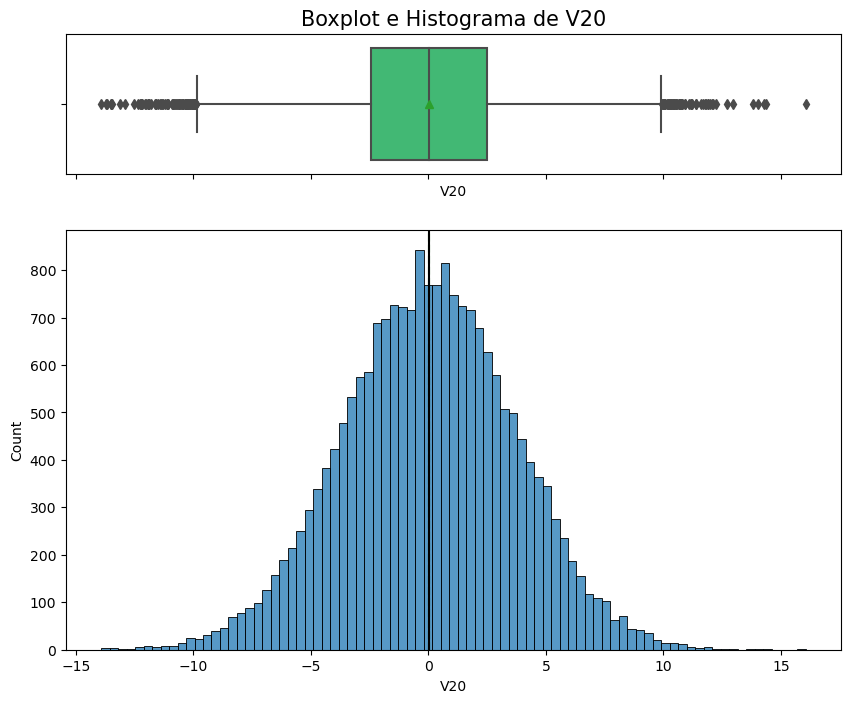

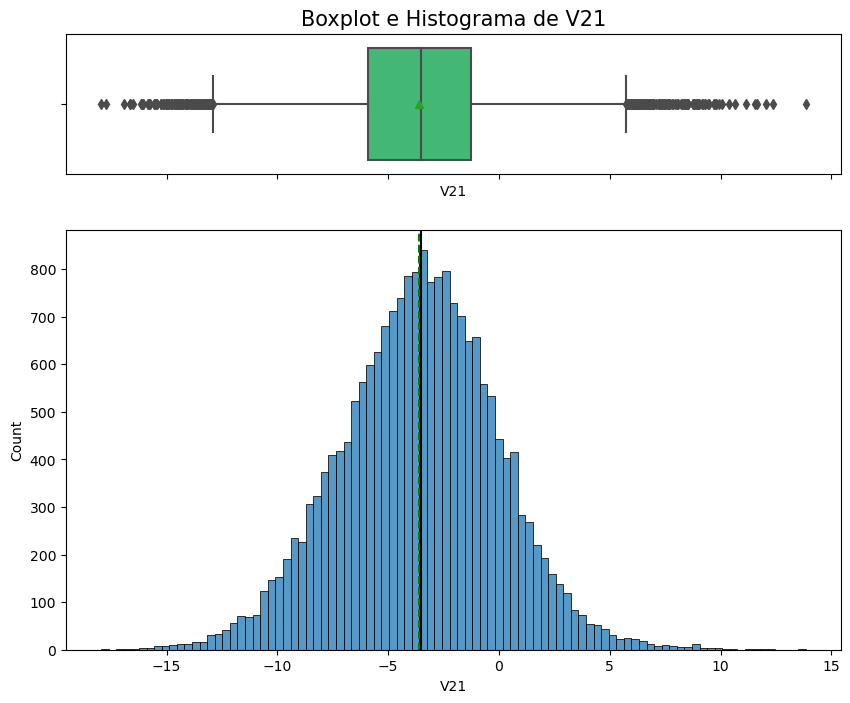

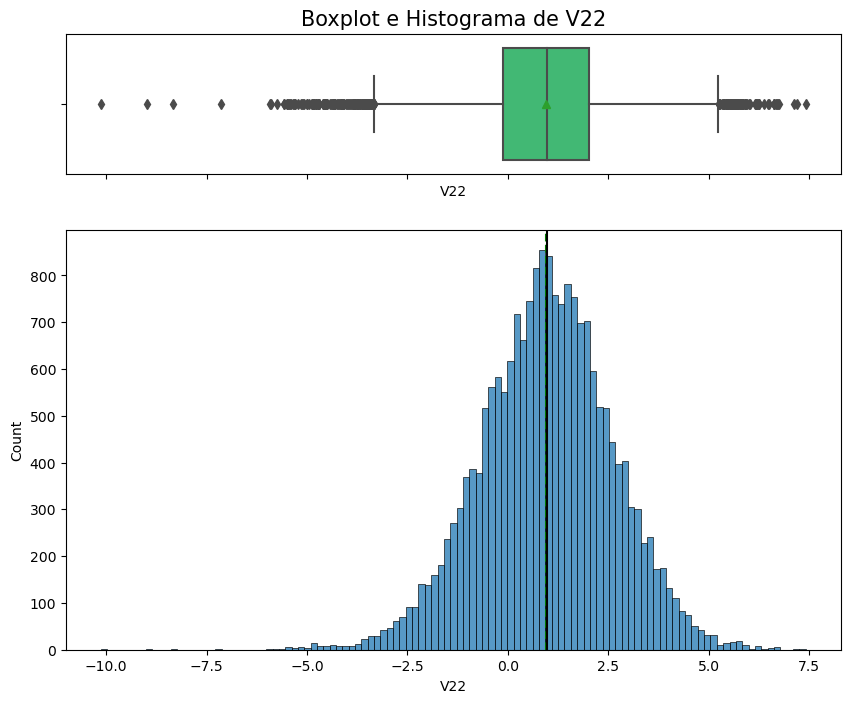

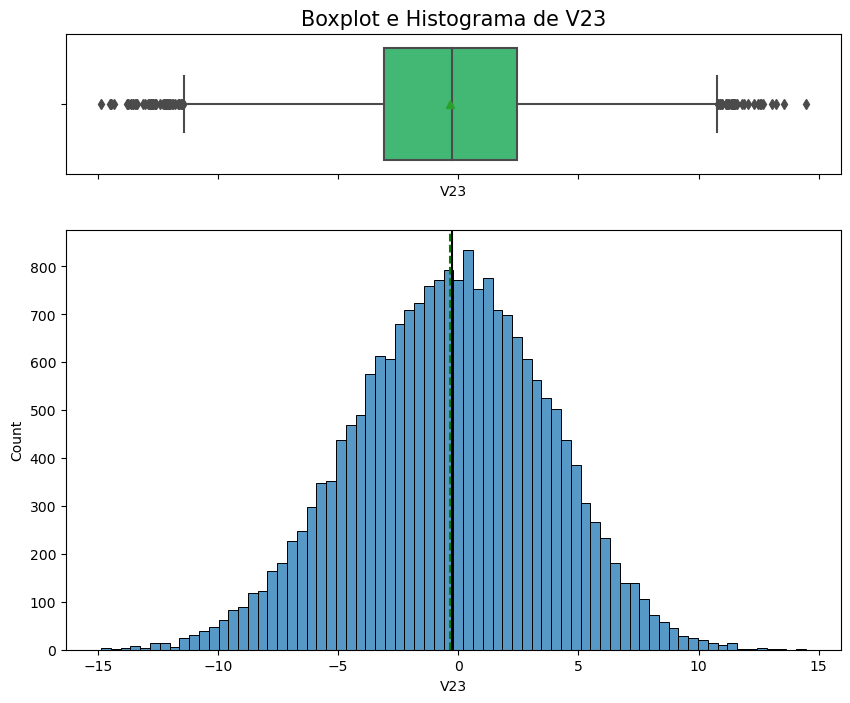

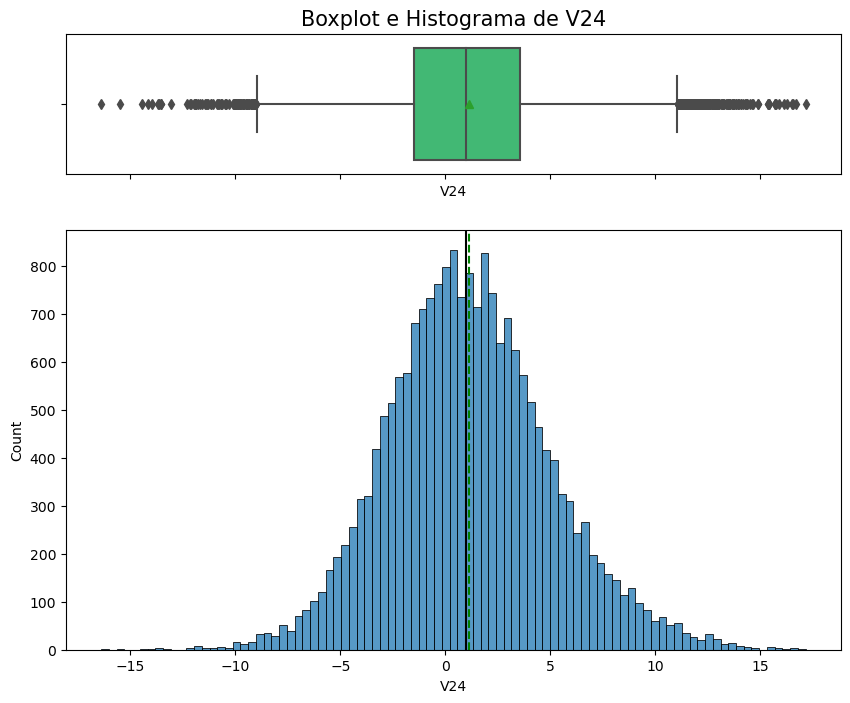

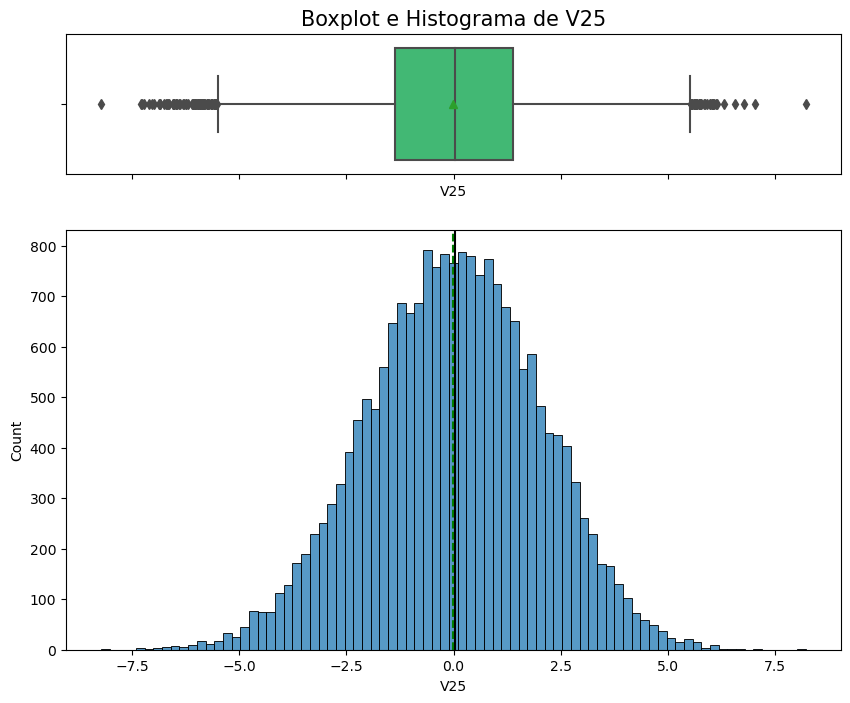

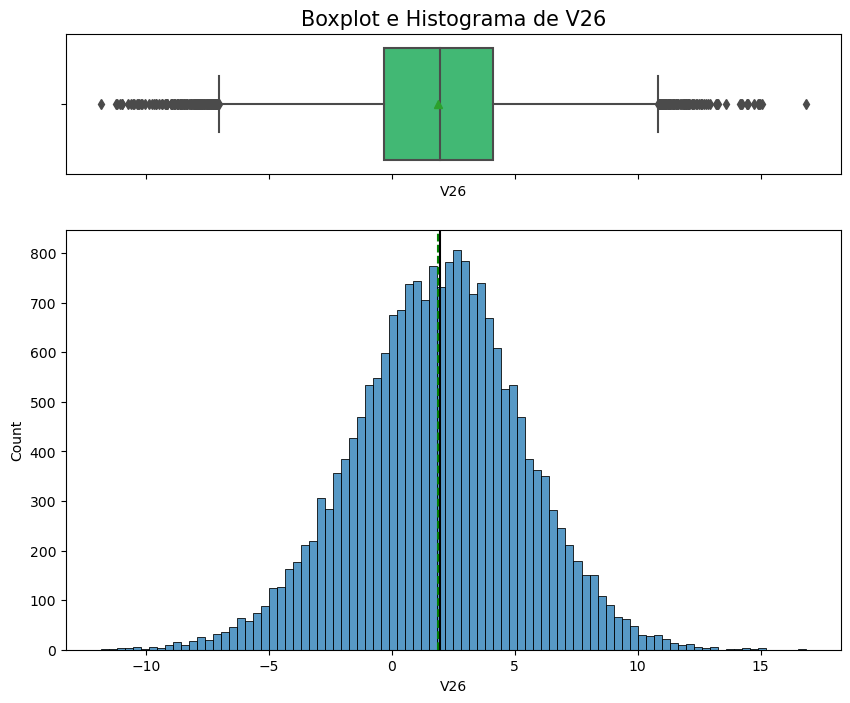

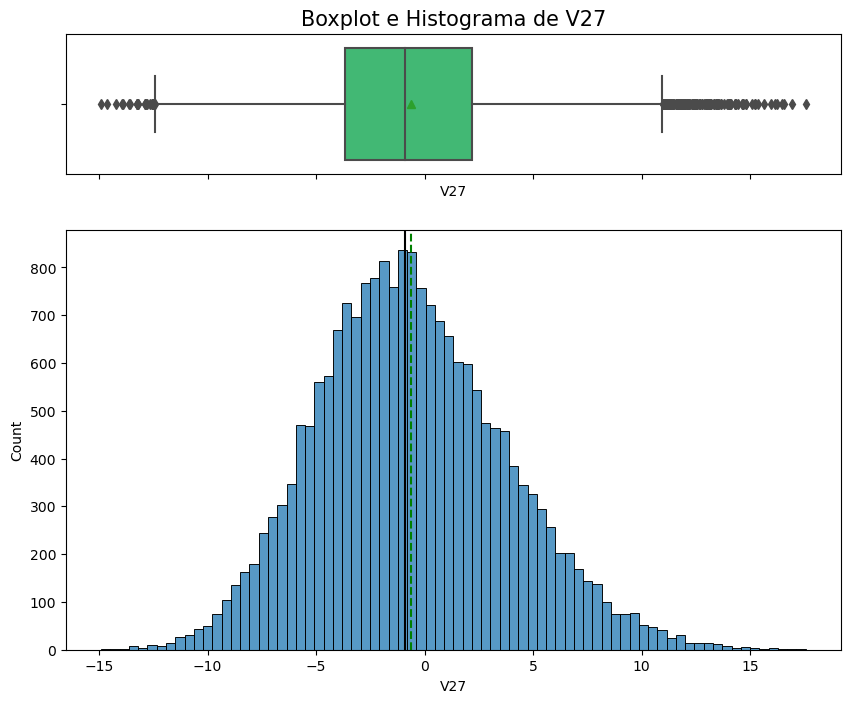

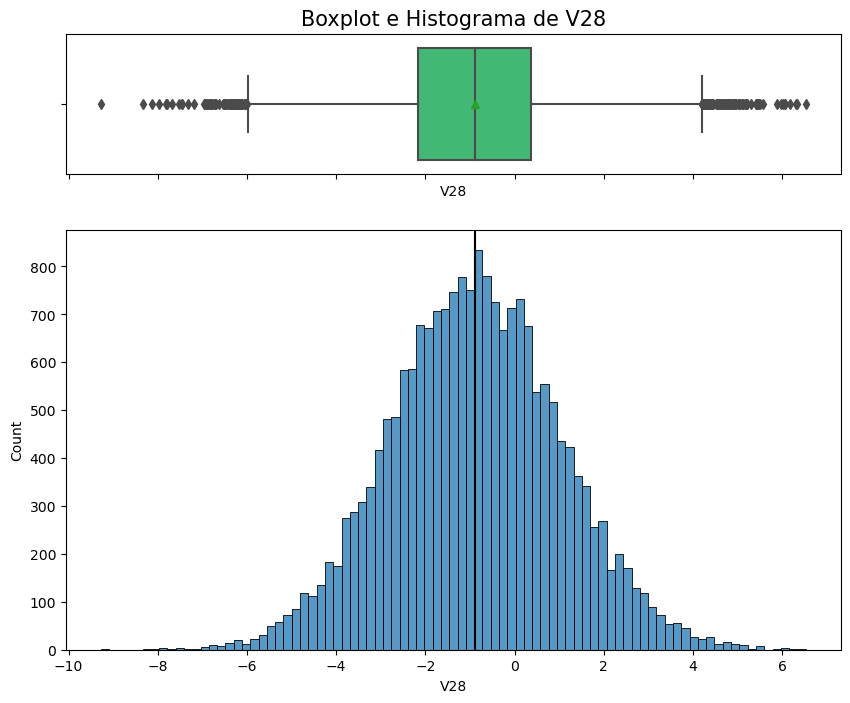

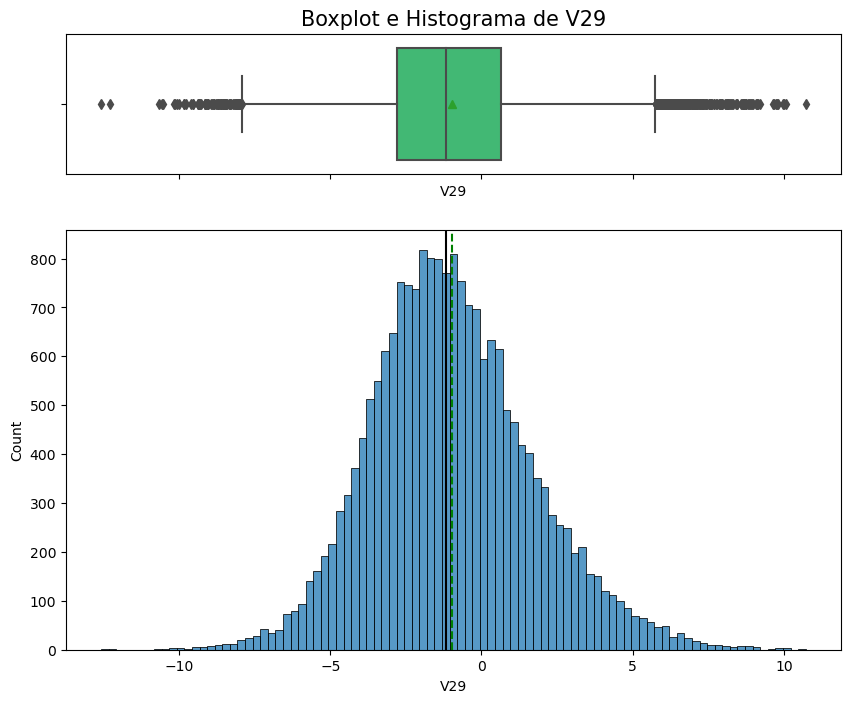

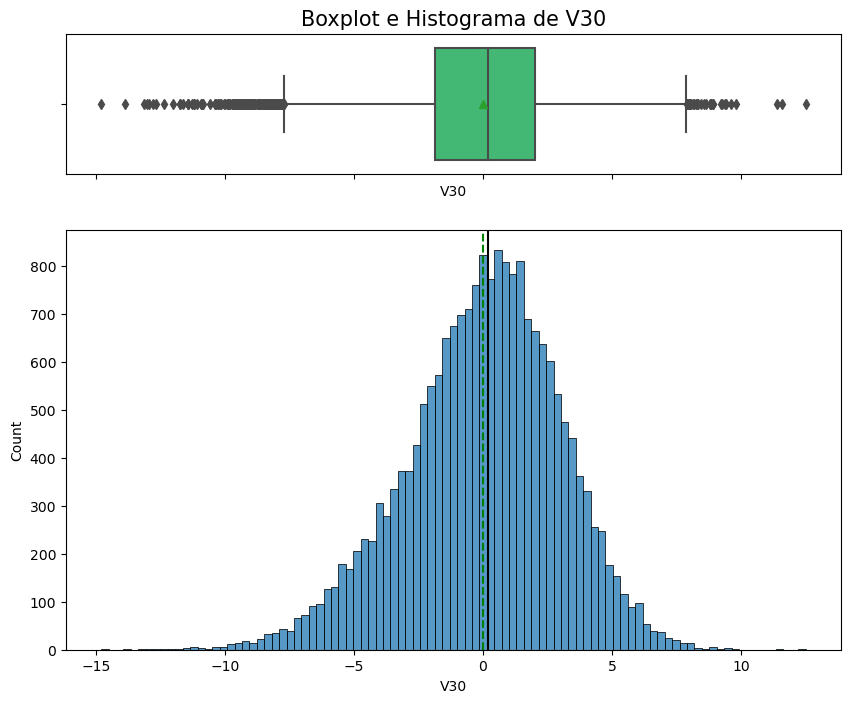

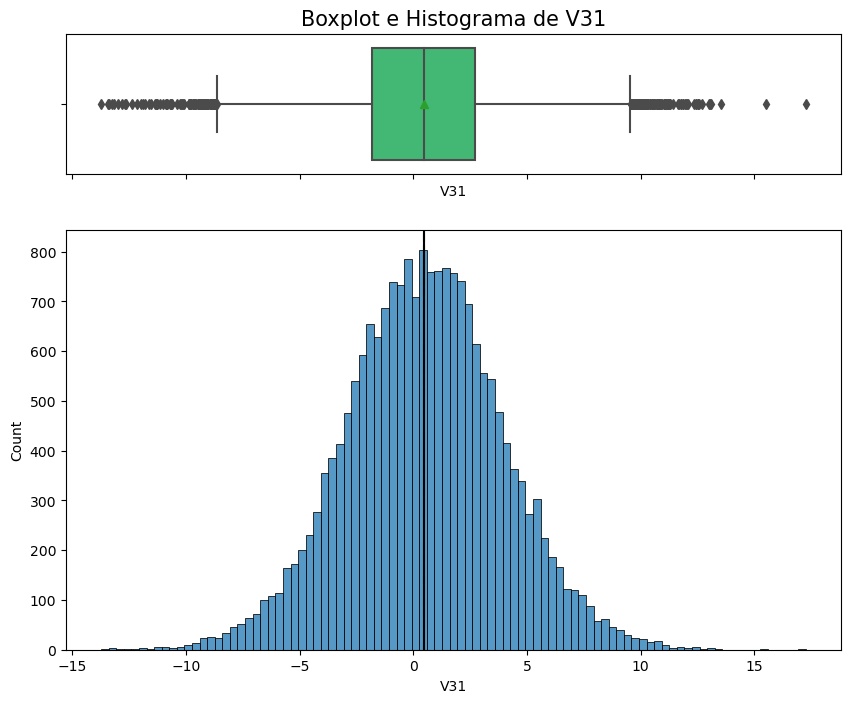

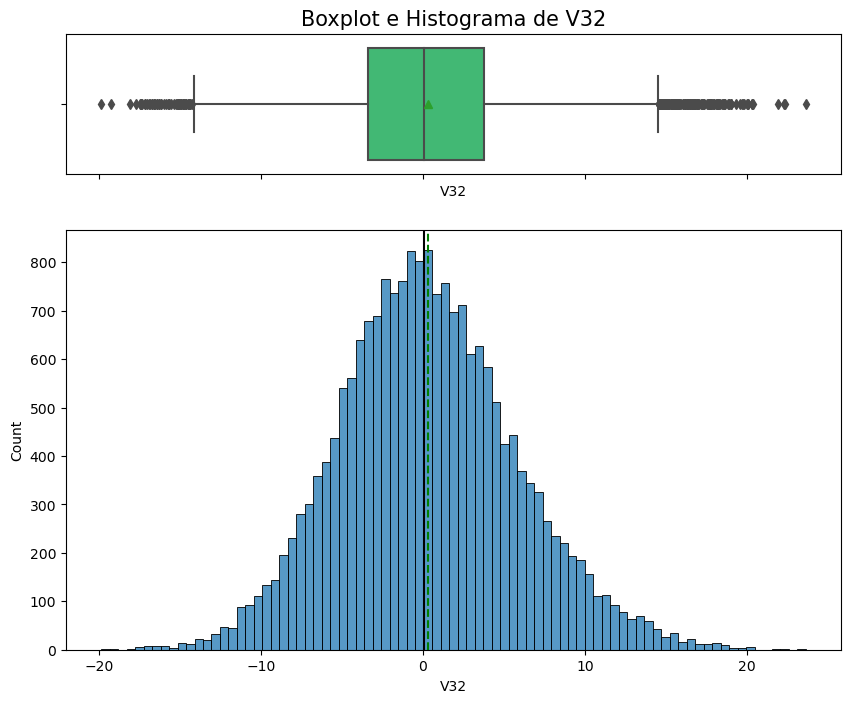

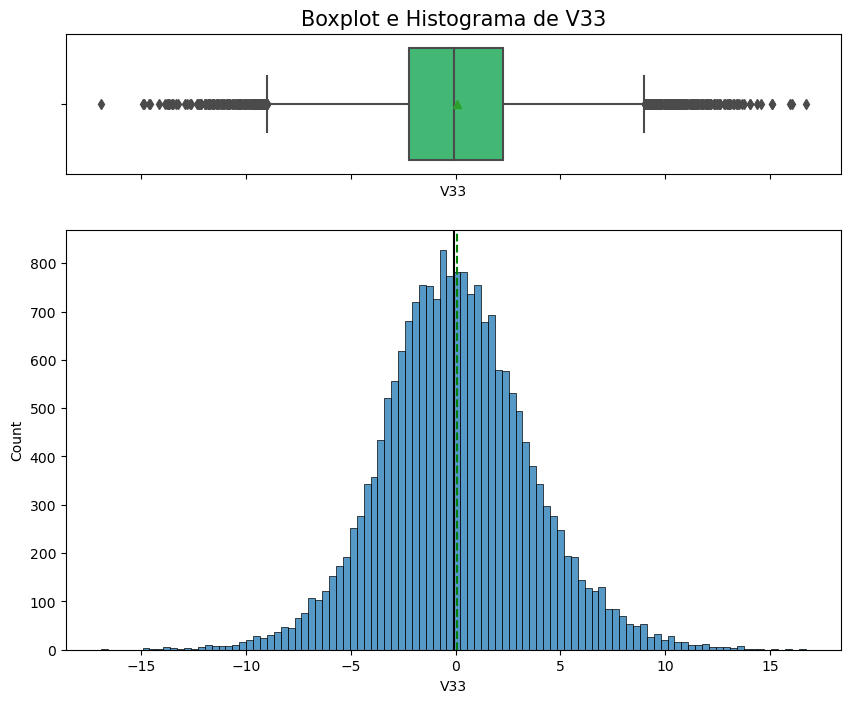

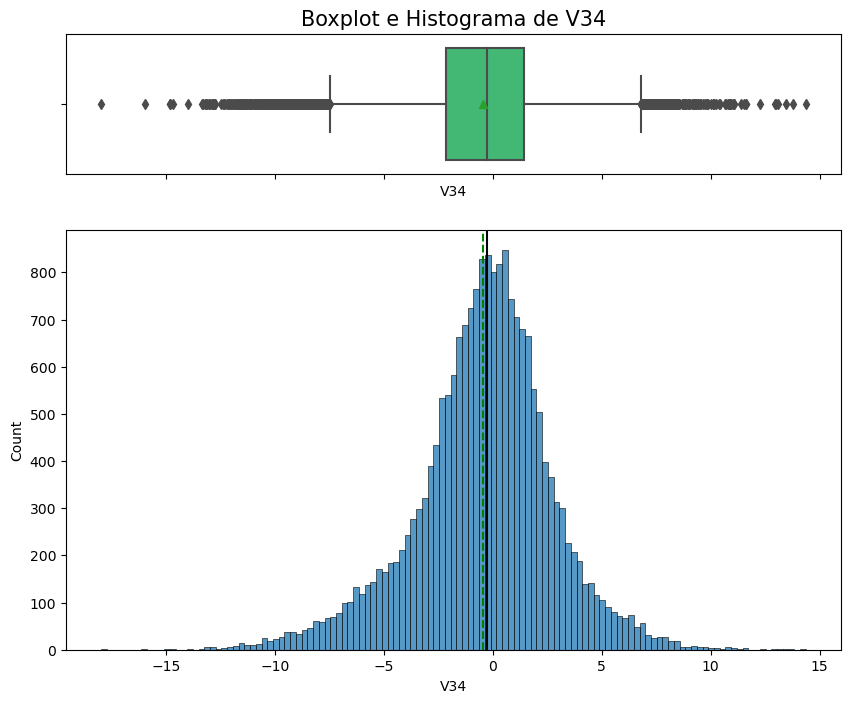

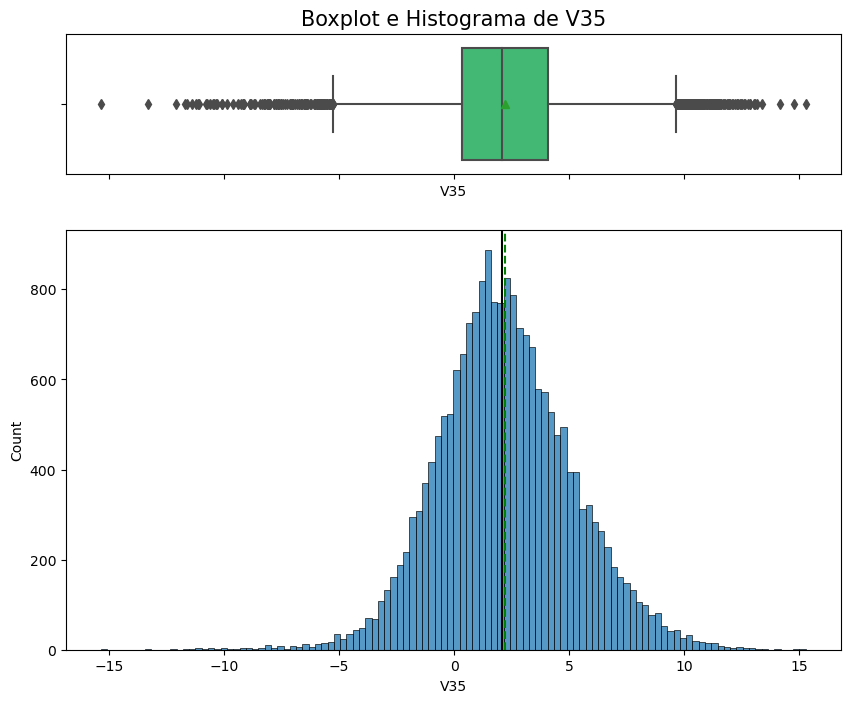

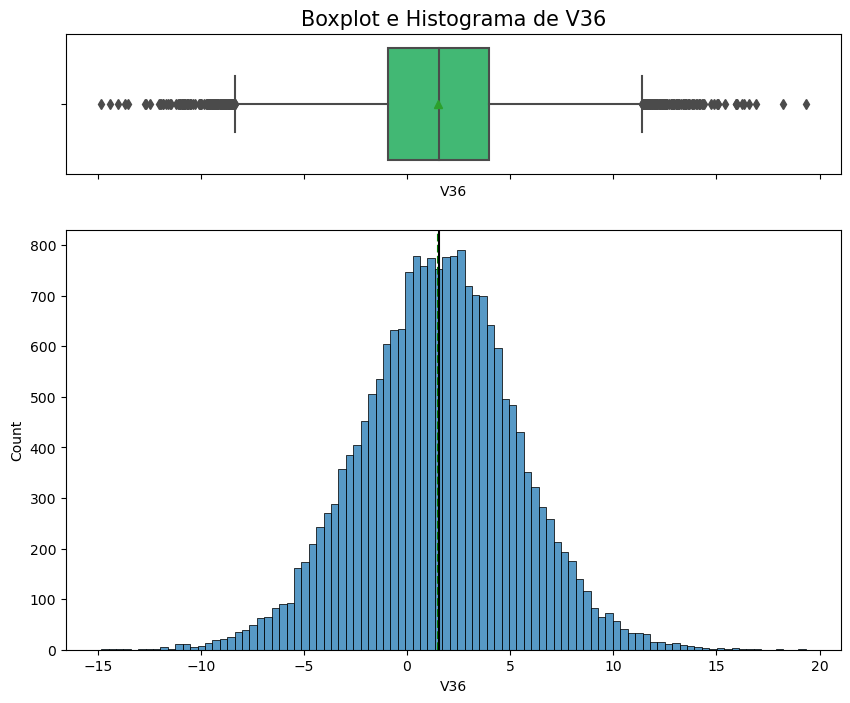

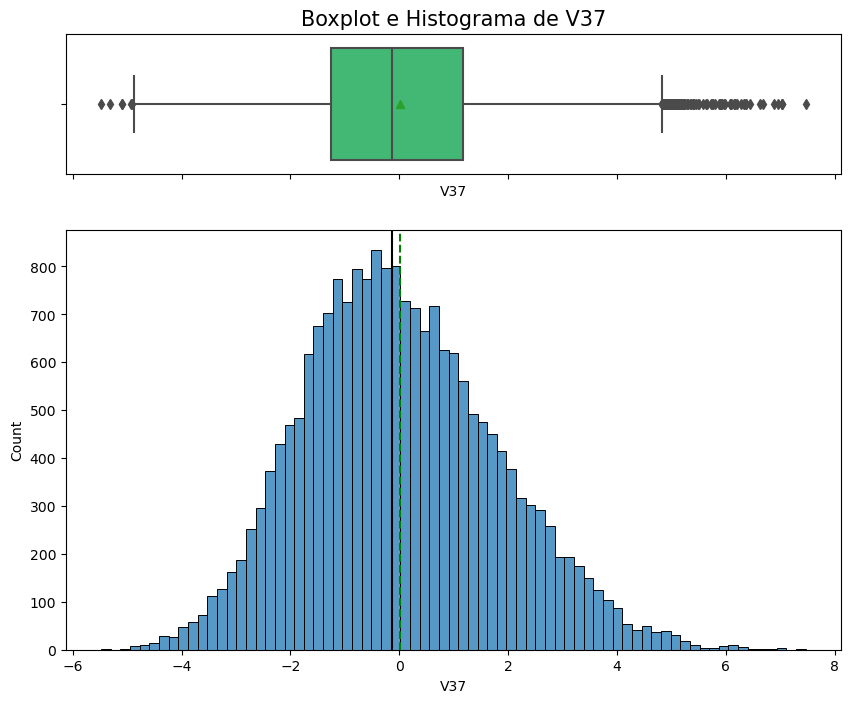

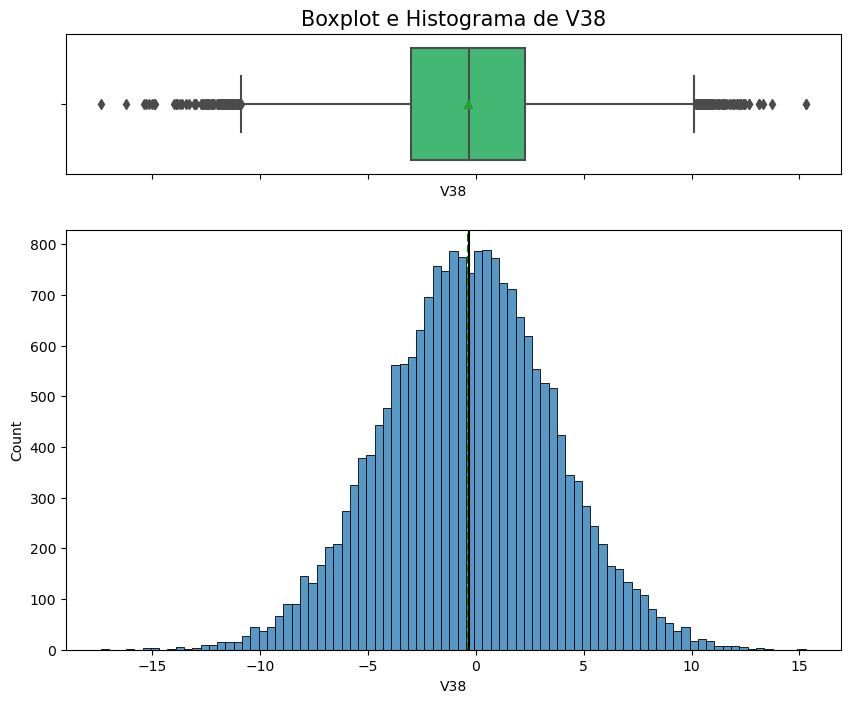

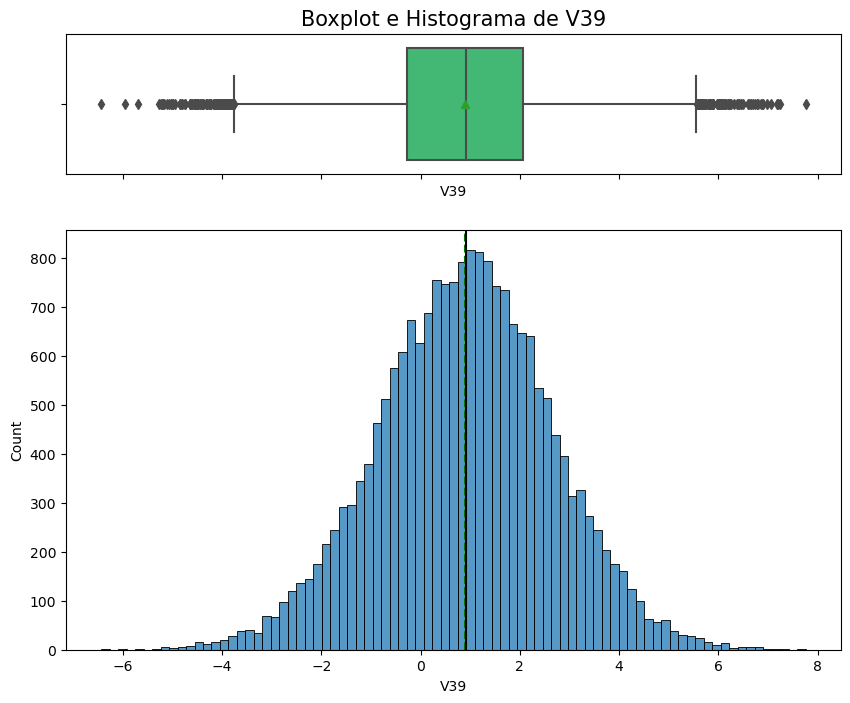

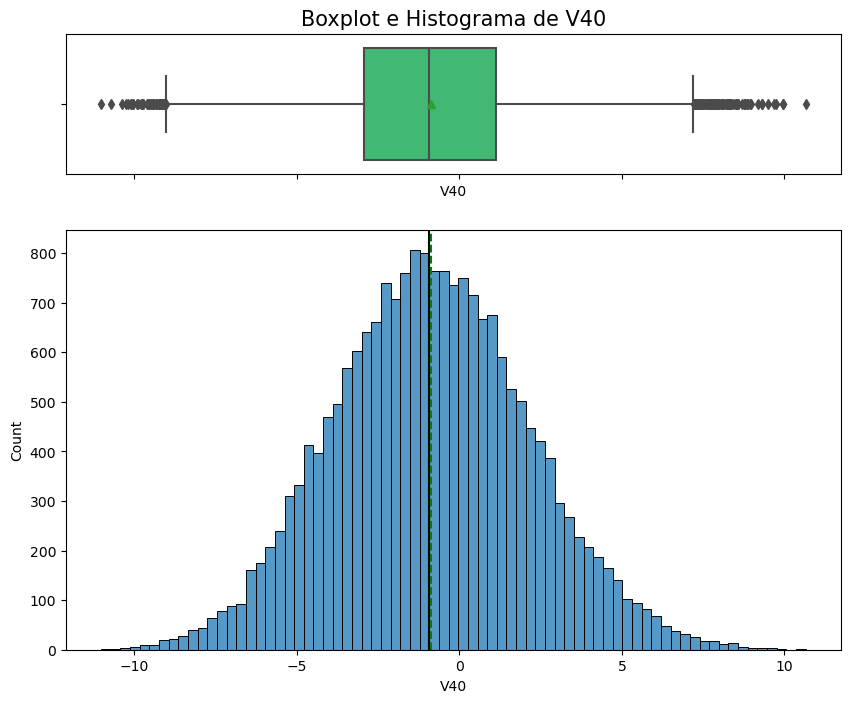

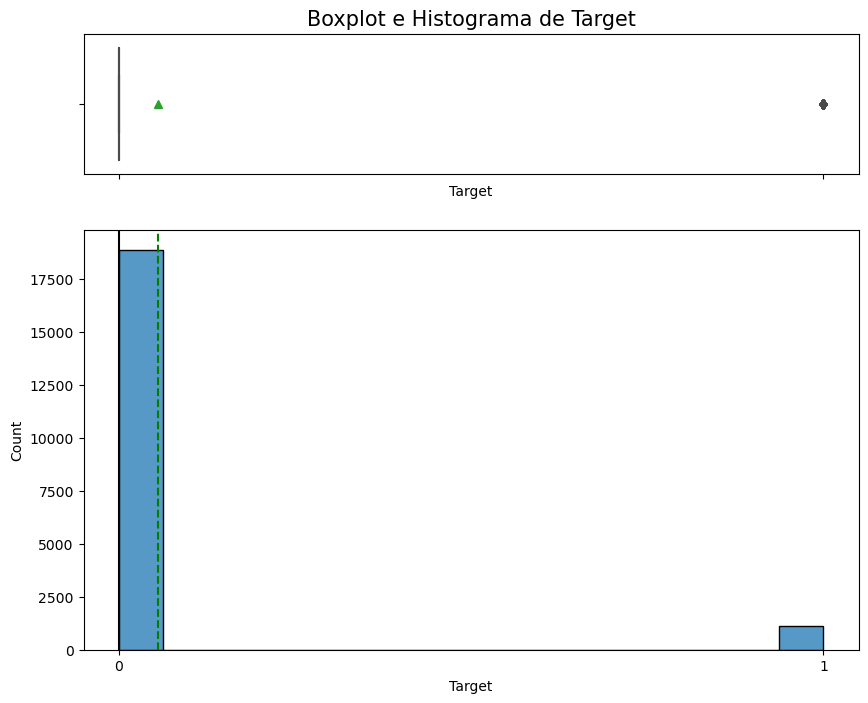

In [11]:
# Mostrando los graficos de las variables numéricas
for i in df_numericas:
    plot_boxplot_histogram(data, i)

* Notamos presencia de outliers en la mayoria de las variables.
* Notamos que la mayoria de las variables a excepción del target presentan una distribución uniforme, por lo cual ya no será necesario tratamiento de datos por distribución

---

## Preprocesamiento de datos

In [12]:
df = data.copy()
df_test = data_test.copy()

In [13]:
# División de los datos con el target
X = df.drop(["Target"], axis=1)
y = df["Target"]

In [14]:
# Dividismo el 25% como datos de validación
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)

In [15]:
print('Entrenamiento: ', X_train.shape)
print('Evaluación: ', X_val.shape)

Entrenamiento:  (15000, 40)
Evaluación:  (5000, 40)


In [16]:
# Dividing test data into X_test and y_test
X_test = df_test.drop(["Target"], axis=1)
y_test = df_test["Target"]

In [17]:
print('Testing: ', X_test.shape)

Testing:  (5000, 40)


## Imputación de valor faltante

In [18]:
# Verificamos valores faltantes
print(X_train.isna().sum(), '\n')
print(X_val.isna().sum(), '\n')
print(X_test.isna().sum(), '\n')

V1     15
V2     14
V3      0
V4      0
V5      0
V6      0
V7      0
V8      0
V9      0
V10     0
V11     0
V12     0
V13     0
V14     0
V15     0
V16     0
V17     0
V18     0
V19     0
V20     0
V21     0
V22     0
V23     0
V24     0
V25     0
V26     0
V27     0
V28     0
V29     0
V30     0
V31     0
V32     0
V33     0
V34     0
V35     0
V36     0
V37     0
V38     0
V39     0
V40     0
dtype: int64 

V1     3
V2     4
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64 

V1     5
V2     6
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24

* Notamos que en los tres conjuntos de datos tenemos valores faltantes para las variables "V1" y "V2"

In [19]:
# Utilizamos la mediana para imputar valores faltantes
imputer = SimpleImputer(strategy="median")

# Utilizar las medinas que se calcularon de X_train para completar los valores faltantes de X_val y X_test y asi evitar fuga de datos
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

In [20]:
# Comprobar la imputación de datos
print(X_train.isna().sum(), '\n')
print(X_val.isna().sum(), '\n')
print(X_test.isna().sum(), '\n')

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64 

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64 

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    

* Ya no existen valores faltantes

---

## Construcción del modelo

### Criterio de evaluación del modelo

La naturaleza de las predicciones hechas por el modelo de clasificación se traducirá de la siguiente manera:

- Los verdaderos positivos (TP) son fallas correctamente predichas por el modelo.
- Los falsos negativos (FN) son fallas reales en un generador donde no hay detección por modelo.
- Los falsos positivos (FP) son detecciones de fallas en un generador donde no hay falla.

**¿Qué métrica optimizar?**

* Necesitamos elegir la métrica que garantizará que el modelo prediga correctamente la cantidad máxima de fallas del generador.
* Queremos maximizar el valor de *recall*, ya que cuanto mayor sea, mayores serán las posibilidades de minimizar los falsos negativos.
* Queremos minimizar los falsos negativos porque si un modelo predice que una máquina no fallará cuando la habrá, aumentará el costo de mantenimiento.

**Definamos una función para generar diferentes métricas (incluido el valor *recall*) en el conjunto de prueba y entrenamiento y una función para mostrar la matriz de confusión para que no tengamos que usar el mismo código repetitivamente mientras evaluamos modelos.**

In [21]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
            
        },
        index=[0],
    )

    return df_perf

### Definición de la puntuación que se utilizará para la validación cruzada y el ajuste de hiperparámetros

- Queremos reducir los falsos negativos e intentaremos maximizar "recall".
- Para maximizar Recall, podemos usar Recall como la **puntuación (*score*)** en validación cruzada y ajuste de hiperparámetros.

In [22]:
# Función personalizada para evaluar la eficacia de un modelo en la validación cruzada
scorer = metrics.make_scorer(metrics.recall_score)

### Construcción de modelos con datos originales

Ejemplo de construcción de un modelo de árbol de decisión con datos originales

In [23]:
# Creación de una lista de modelo
models = [] 

# Añadimos modelos a la lista en forma de tupla
models.append(("Logistic regression", LogisticRegression(random_state=22)))
models.append(("Bagging", BaggingClassifier(random_state=22)))
models.append(("Random forest", RandomForestClassifier(random_state=22)))
models.append(("GBM", GradientBoostingClassifier(random_state=22)))
models.append(("Adaboost", AdaBoostClassifier(random_state=22)))
models.append(("Xgboost", XGBClassifier(random_state=22, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=22)))

results1 = []  # Lista vacia que almacena resultados de la validación cruzada
names = []  # Lista vacia que almacena el nombre de los modelos respectivamente

print("\n" "Rendimiento de la validación cruzada en el conjunto de datos de entrenamiento:" "\n")

# Blucle sobre la lista de modelos
for name, model in models:
    kfold = StratifiedKFold( # Para cada modelo se hace una validación cruzada con 5 divisiones
        n_splits=5, shuffle=True, random_state=22
    )  
    cv_result = cross_val_score( # calcular los resultados de la validación cruzada
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

# Evaluación del rendimiento en el conjunto de validación
for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Rendimiento de la validación cruzada en el conjunto de datos de entrenamiento:

Logistic regression: 0.4915229781401053
Bagging: 0.6983623115215352
Random forest: 0.7235336555804055
GBM: 0.7115503931895246
Adaboost: 0.6189452420460284
Xgboost: 0.8052882187432363
dtree: 0.7151720655075391

Validation Performance:

Logistic regression: 0.48201438848920863
Bagging: 0.7122302158273381
Random forest: 0.7302158273381295
GBM: 0.7230215827338129
Adaboost: 0.6762589928057554
Xgboost: 0.8201438848920863
dtree: 0.7230215827338129


* Incluyo como mejores modelos "GBM(0.71,0.72)", "Random forest(0.72,0.73)", "XGBoost(0.80,0.82)", resultados de Recall obtenidos para los datos de entrenamiento como para la validación respectivamente

### Creación de modelos con datos sobremuestreados

In [24]:
print('ANTES:')
print('Label -> 1: ',sum(y_train == 1))
print('Label -> 0: ',sum(y_train == 0))
print('\n')

# Aplicamos el sobremuestreo
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=22)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

print('DESPUES:')
print('Label -> 1: ',sum(y_train_over == 1))
print('Label -> 0: ',sum(y_train_over == 0))

ANTES:
Label -> 1:  832
Label -> 0:  14168


DESPUES:
Label -> 1:  14168
Label -> 0:  14168


In [25]:
# Creación de una lista de modelo
models = [] 

# Añadimos modelos a la lista en forma de tupla
models.append(("Logistic regression", LogisticRegression(random_state=22)))
models.append(("Bagging", BaggingClassifier(random_state=22)))
models.append(("Random forest", RandomForestClassifier(random_state=22)))
models.append(("GBM", GradientBoostingClassifier(random_state=22)))
models.append(("Adaboost", AdaBoostClassifier(random_state=22)))
models.append(("Xgboost", XGBClassifier(random_state=22, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=22)))

results1 = []  # Lista vacia que almacena resultados de la validación cruzada
names = []  # Lista vacia que almacena el nombre de los modelos respectivamente

print("\n" "Rendimiento de la validación cruzada en el conjunto de datos de entrenamiento:" "\n")

# Blucle sobre la lista de modelos
for name, model in models:
    kfold = StratifiedKFold( # Para cada modelo se hace una validación cruzada con 5 divisiones
        n_splits=5, shuffle=True, random_state=22
    )  
    cv_result = cross_val_score( # calcular los resultados de la validación cruzada
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

# Evaluación del rendimiento en el conjunto de validación
for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Rendimiento de la validación cruzada en el conjunto de datos de entrenamiento:

Logistic regression: 0.8854462266846455
Bagging: 0.9769909831228432
Random forest: 0.9829196726452851
GBM: 0.9292073383534765
Adaboost: 0.8970224401841289
Xgboost: 0.9911069034399247
dtree: 0.9721207684112116

Validation Performance:

Logistic regression: 0.8453237410071942
Bagging: 0.8453237410071942
Random forest: 0.8525179856115108
GBM: 0.8812949640287769
Adaboost: 0.8633093525179856
Xgboost: 0.8561151079136691
dtree: 0.7949640287769785


* Incluyo como mejores modelos "dtree(0.97,0.79)", "Random forest(0.98,0.85)", "XGBoost(0.99,0.85)", resultados de Recall obtenidos para los datos de entrenamiento como para la validación respectivamente

### Creación de modelos con datos submuestreados

In [26]:
print('ANTES:')
print('Label -> 1: ',sum(y_train == 1))
print('Label -> 0: ',sum(y_train == 0))
print('\n')

# Aplicamos el submuestreados
rus = RandomUnderSampler(random_state=22, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

print('DESPUES:')
print('Label -> 1: ',sum(y_train_un == 1))
print('Label -> 0: ',sum(y_train_un == 0))

ANTES:
Label -> 1:  832
Label -> 0:  14168


DESPUES:
Label -> 1:  832
Label -> 0:  832


In [27]:
# Creación de una lista de modelo
models = [] 

# Añadimos modelos a la lista en forma de tupla
models.append(("Logistic regression", LogisticRegression(random_state=22)))
models.append(("Bagging", BaggingClassifier(random_state=22)))
models.append(("Random forest", RandomForestClassifier(random_state=22)))
models.append(("GBM", GradientBoostingClassifier(random_state=22)))
models.append(("Adaboost", AdaBoostClassifier(random_state=22)))
models.append(("Xgboost", XGBClassifier(random_state=22, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=22)))

results1 = []  # Lista vacia que almacena resultados de la validación cruzada
names = []  # Lista vacia que almacena el nombre de los modelos respectivamente

print("\n" "Rendimiento de la validación cruzada en el conjunto de datos de entrenamiento:" "\n")

# Blucle sobre la lista de modelos
for name, model in models:
    kfold = StratifiedKFold( # Para cada modelo se hace una validación cruzada con 5 divisiones
        n_splits=5, shuffle=True, random_state=22
    )  
    cv_result = cross_val_score( # calcular los resultados de la validación cruzada
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

# Evaluación del rendimiento en el conjunto de validación
for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Rendimiento de la validación cruzada en el conjunto de datos de entrenamiento:

Logistic regression: 0.8629968977707236
Bagging: 0.8653776783781832
Random forest: 0.8966669071495563
GBM: 0.8894524204602842
Adaboost: 0.8774547290960248
Xgboost: 0.8990765457037732
dtree: 0.8389365846620013

Validation Performance:

Logistic regression: 0.8561151079136691
Bagging: 0.8776978417266187
Random forest: 0.8848920863309353
GBM: 0.8884892086330936
Adaboost: 0.8453237410071942
Xgboost: 0.89568345323741
dtree: 0.8345323741007195


* Incluyo como mejores modelos "GBM(0.88,0.88)", "Random forest(0.89,0.88)", "XGBoost(0.89,0.89)", resultados de Recall obtenidos para los datos de entrenamiento como para la validación respectivamente

**CONCLUSIÓN**
* Despues de revisar los resultados de validación de los modelos tanto con valores submuestrados como con valores sobre muestrados tomo como mejores modelos:
* **XGBoost**, En todas las configuraciones, XGBoost tuvo el mejor rendimiento o estuvo muy cerca del mejor. Es un modelo potente y flexible que a menudo funciona muy bien en una variedad de problemas de clasificación.
* **Random Forest**,Este modelo también tuvo un buen desempeño en todas las configuraciones. Los modelos de Random Forest son menos propensos a sobreajustarse que los árboles de decisión simples y también pueden manejar bien las características categóricas y numéricas.
* **Gradient Boosting (GBM)**, Al igual que XGBoost, GBM es un algoritmo de potenciación que generalmente funciona bien en muchos problemas. Aunque su rendimiento fue un poco menor que el de XGBoost y Random Forest en tus datos, todavía estaba bastante cerca y podría mejorar con un ajuste de hiperparámetros.

Todos estos modelos son algoritmo de ensamblado que combinan las predicciones de varios modelos base más debiles para hacer una predicción final y segun mi punto de vista los mejores para problemas de clasificación porque son menos propensos a sobreajuste y pueden capturar relaciones complejas entre los datos.

## Sintonización de hiperparámetros

### Muestras de cuadrículas de parámetros

**El ajuste de hiperparámetros puede tardar mucho tiempo en ejecutarse, así que para evitar esa complejidad de tiempo, puede utilizar las siguientes cuadrículas, cuando sea necesario.**

- Para Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7], 
    "max_features":[0.5,0.7]
}

- Para Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- Para Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1], 
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- Para Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- Para Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6), 
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- Para Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- Para XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### AJUSTE CON DATOS ORIGINALES 

#### GRADIENT BOOSTING

In [28]:
%%time 
# GRADIENT BOOSTING

Model = GradientBoostingClassifier(random_state=22)

#Parametros establecidos 
param_grid={"n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7]}

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, scoring=scorer, n_iter=50, n_jobs = -1, cv=5, random_state=22)

# Entrenamos con los nuevos parametros
randomized_cv.fit(X_train, y_train)

print("Los mejores parametros son: {} con CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Los mejores parametros son: {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} con CV score=0.7597215208137941:
CPU times: user 5.37 s, sys: 96.2 ms, total: 5.46 s
Wall time: 1min 9s


In [29]:
# Creando el pipeline con los mejores parametros
tuned_gbm = GradientBoostingClassifier(
    max_features=0.5,
    random_state=22,
    learning_rate=0.2,
    n_estimators=125,
    subsample=0.7
)

tuned_gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=22, subsample=0.7)

In [30]:
gbm_train_perf = model_performance_classification_sklearn(
    tuned_gbm, X_train, y_train
)
gbm_train_perf

,Accuracy,Recall,Precision,F1
0,0.995,0.921,0.988,0.953


In [31]:
gbm_val_perf = model_performance_classification_sklearn(tuned_gbm, X_val, y_val)
gbm_val_perf

,Accuracy,Recall,Precision,F1
0,0.981,0.766,0.873,0.816


* Buenas metricas en los datos de entrenamiento, pero se ve un ligero bajón en los datos de validación

#### Random Forest

In [32]:
%%time 

# Difiniendo el modelo
Model = RandomForestClassifier(random_state=22)

# Parametros establecidos 
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=22)

# Entrenamos con los nuevos parametros
randomized_cv.fit(X_train,y_train) 

print("Los mejores parametros son: {} con CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Los mejores parametros son: {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} con CV score=0.7032537334968617:
CPU times: user 10.9 s, sys: 23.5 ms, total: 10.9 s
Wall time: 2min 4s


In [33]:
# Creando el pipeline con los mejores parametros
tuned_rf = RandomForestClassifier(
    max_features="sqrt",
    random_state=22,
    max_samples=0.6,
    n_estimators=250,
    min_samples_leaf=1,
)

tuned_rf.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', max_samples=0.6, n_estimators=250,
                       random_state=22)

In [34]:
rf_train_perf = model_performance_classification_sklearn(
    tuned_rf, X_train, y_train
)
rf_train_perf

,Accuracy,Recall,Precision,F1
0,0.995,0.913,1.000,0.955


In [35]:
rf_val_perf = model_performance_classification_sklearn(tuned_rf, X_val, y_val)
rf_val_perf

,Accuracy,Recall,Precision,F1
0,0.984,0.723,0.985,0.834


* Notamos un bajo Recall

#### XGBoost

In [36]:
%%time 

# Difiniendo el modelo
Model = XGBClassifier(random_state=22,eval_metric='logloss')

# Parametros establecidos 
param_grid={'n_estimators':[150,200,250],
            'scale_pos_weight':[5,10], 
            'learning_rate':[0.1,0.2], 
            'gamma':[0,3,5], 
            'subsample':[0.8,0.9]}

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

# Entrenamos con los nuevos parametros
randomized_cv.fit(X_train,y_train)

print("Los mejores parametros son: {} con CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Los mejores parametros son: {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} con CV score=0.8534016304739918:
CPU times: user 23.8 s, sys: 103 ms, total: 23.9 s
Wall time: 5min 23s


In [37]:
xgb = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.8,
    scale_pos_weight=10,
    n_estimators=200,
    learning_rate=0.1,
    gamma=5,
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

In [38]:
xgb_train_perf = model_performance_classification_sklearn(
    xgb, X_train, y_train
)
xgb_train_perf

,Accuracy,Recall,Precision,F1
0,0.999,1.000,0.983,0.992


In [39]:
xgb_val_perf = model_performance_classification_sklearn(xgb, X_val, y_val)
xgb_val_perf

,Accuracy,Recall,Precision,F1
0,0.989,0.853,0.937,0.893


* Notamos overfitting entre el valor Recall al no ajustarte de manera efectiva con los datos de validación

---

### AJUSTE CON DATOS SUBMUESTRADOS

#### GRADIENT BOOSTING

In [40]:
%%time 
# GRADIENT BOOSTING

Model = GradientBoostingClassifier(random_state=22)

#Parametros establecidos 
param_grid={"n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7]}

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, scoring=scorer, n_iter=50, n_jobs = -1, cv=5, random_state=22)

# Entrenamos con los nuevos parametros
randomized_cv.fit(X_train_un, y_train_un)

print("Los mejores parametros son: {} con CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Los mejores parametros son: {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} con CV score=0.9038381069186927:
CPU times: user 644 ms, sys: 11.8 ms, total: 656 ms
Wall time: 6.7 s


In [41]:
# Creando el pipeline con los mejores parametros
tuned_gbm_un = GradientBoostingClassifier(
    max_features=0.5,
    random_state=22,
    learning_rate=0.2,
    n_estimators=125,
    subsample=0.7
)

tuned_gbm_un.fit(X_train_un, y_train_un)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=22, subsample=0.7)

In [42]:
gbm_train_perf_un = model_performance_classification_sklearn(
    tuned_gbm_un, X_train_un, y_train_un
)
gbm_train_perf_un

,Accuracy,Recall,Precision,F1
0,0.999,0.998,1.000,0.999


In [43]:
gbm_val_perf_un = model_performance_classification_sklearn(tuned_gbm_un, X_val, y_val)
gbm_val_perf_un

,Accuracy,Recall,Precision,F1
0,0.924,0.888,0.416,0.567


#### Random Forest

In [44]:
%%time 

# Difiniendo el modelo
Model = RandomForestClassifier(random_state=22)

# Parametros establecidos 
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=22)

# Entrenamos con los nuevos parametros
randomized_cv.fit(X_train_un,y_train_un) 

print("Los mejores parametros son: {} con CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Los mejores parametros son: {'n_estimators': 250, 'min_samples_leaf': 2, 'max_samples': 0.6, 'max_features': 'sqrt'} con CV score=0.9014356828511652:
CPU times: user 947 ms, sys: 20.2 ms, total: 967 ms
Wall time: 9.64 s


In [45]:
# Creando el pipeline con los mejores parametros
tuned_rf_un = RandomForestClassifier(
    max_features="sqrt",
    random_state=22,
    max_samples=0.6,
    n_estimators=250,
    min_samples_leaf=2,
)

tuned_rf_un.fit(X_train_un, y_train_un)

RandomForestClassifier(max_features='sqrt', max_samples=0.6, min_samples_leaf=2,
                       n_estimators=250, random_state=22)

In [46]:
rf_train_perf_un = model_performance_classification_sklearn(
    tuned_rf_un, X_train_un, y_train_un
)
rf_train_perf_un

,Accuracy,Recall,Precision,F1
0,0.973,0.946,1.000,0.972


In [47]:
rf_val_perf_un = model_performance_classification_sklearn(tuned_rf_un, X_val, y_val)
rf_val_perf_un

,Accuracy,Recall,Precision,F1
0,0.935,0.881,0.457,0.602


#### XGBoost

In [48]:
%%time 

# Difiniendo el modelo
Model = XGBClassifier(random_state=22,eval_metric='logloss')

# Parametros establecidos 
param_grid={'n_estimators':[150,200,250],
            'scale_pos_weight':[5,10], 
            'learning_rate':[0.1,0.2], 
            'gamma':[0,3,5], 
            'subsample':[0.8,0.9]}

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=22)

# Entrenamos con los nuevos parametros
randomized_cv.fit(X_train_un,y_train_un)

print("Los mejores parametros son: {} con CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Los mejores parametros son: {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.2, 'gamma': 5} con CV score=0.9254599235264411:
CPU times: user 4.44 s, sys: 91.3 ms, total: 4.53 s
Wall time: 32.3 s


In [49]:
xgb_un = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.9,
    scale_pos_weight=10,
    n_estimators=250,
    learning_rate=0.2,
    gamma=5,
)

xgb_un.fit(X_train_un, y_train_un)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

In [50]:
xgb_train_perf_un = model_performance_classification_sklearn(
    xgb_un, X_train_un, y_train_un
)
xgb_train_perf_un

,Accuracy,Recall,Precision,F1
0,0.995,1.000,0.990,0.995


In [51]:
xgb_val_perf_un = model_performance_classification_sklearn(xgb_un, X_val, y_val)
xgb_val_perf_un

,Accuracy,Recall,Precision,F1
0,0.852,0.914,0.261,0.406


### AJUSTE CON DATOS SOBREMUESTRADOS

#### GRADIENT BOOSTING

In [52]:
%%time 
# GRADIENT BOOSTING

Model = GradientBoostingClassifier(random_state=22)

#Parametros establecidos 
param_grid={"n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7]}

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, scoring=scorer, n_iter=50, n_jobs = -1, cv=5, random_state=22)

# Entrenamos con los nuevos parametros
randomized_cv.fit(X_train_over, y_train_over)

print("Los mejores parametros son: {} con CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Los mejores parametros son: {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} con CV score=0.9693677524268495:
CPU times: user 10.7 s, sys: 20.1 ms, total: 10.7 s
Wall time: 2min 16s


In [53]:
# Creando el pipeline con los mejores parametros
tuned_gbm_over = GradientBoostingClassifier(
    max_features=0.5,
    random_state=22,
    learning_rate=1,
    n_estimators=125,
    subsample=0.7
)

tuned_gbm_over.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.5, n_estimators=125,
                           random_state=22, subsample=0.7)

In [54]:
gbm_train_perf_over = model_performance_classification_sklearn(
    tuned_gbm_over, X_train_over, y_train_over
)
gbm_train_perf_over

,Accuracy,Recall,Precision,F1
0,0.993,0.993,0.994,0.993


In [55]:
gbm_val_perf_over = model_performance_classification_sklearn(tuned_gbm_over, X_val, y_val)
gbm_val_perf_over

,Accuracy,Recall,Precision,F1
0,0.966,0.838,0.653,0.734


#### Random Forest

In [56]:
%%time 

# Difiniendo el modelo
Model = RandomForestClassifier(random_state=22)

# Parametros establecidos 
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=22)

# Entrenamos con los nuevos parametros
randomized_cv.fit(X_train_over,y_train_over) 

print("Los mejores parametros son: {} con CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Los mejores parametros son: {'n_estimators': 200, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} con CV score=0.9812959272970219:
CPU times: user 12.3 s, sys: 32.9 ms, total: 12.3 s
Wall time: 2min 58s


In [57]:
# Creando el pipeline con los mejores parametros
tuned_rf_over = RandomForestClassifier(
    max_features="sqrt",
    random_state=22,
    max_samples=0.6,
    n_estimators=200,
    min_samples_leaf=1,
)

tuned_rf_over.fit(X_train_over, y_train_over)

RandomForestClassifier(max_features='sqrt', max_samples=0.6, n_estimators=200,
                       random_state=22)

In [58]:
rf_train_perf_over = model_performance_classification_sklearn(
    tuned_rf_over, X_train_over, y_train_over
)
rf_train_perf_over

,Accuracy,Recall,Precision,F1
0,0.999,0.999,1.000,0.999


In [59]:
rf_val_perf_over = model_performance_classification_sklearn(tuned_rf_over, X_val, y_val)
rf_val_perf_over

,Accuracy,Recall,Precision,F1
0,0.988,0.860,0.912,0.885


#### XGBoost

In [60]:
%%time 

# Difiniendo el modelo
Model = XGBClassifier(random_state=22,eval_metric='logloss')

# Parametros establecidos 
param_grid={'n_estimators':[150,200,250],
            'scale_pos_weight':[5,10], 
            'learning_rate':[0.1,0.2], 
            'gamma':[0,3,5], 
            'subsample':[0.8,0.9]}

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=22)

# Entrenamos con los nuevos parametros
randomized_cv.fit(X_train_over,y_train_over)

print("Los mejores parametros son: {} con CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Los mejores parametros son: {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.1, 'gamma': 0} con CV score=0.9964710448312945:
CPU times: user 56.7 s, sys: 79.6 ms, total: 56.8 s
Wall time: 10min 59s


In [61]:
xgb_over = XGBClassifier(
    random_state=22,
    eval_metric="logloss",
    subsample=0.8,
    scale_pos_weight=10,
    n_estimators=250,
    learning_rate=0.1,
    gamma=0,
)

xgb_over.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=22, ...)

In [62]:
xgb_train_perf_over = model_performance_classification_sklearn(
    xgb_over, X_train_over, y_train_over
)
xgb_train_perf_over

,Accuracy,Recall,Precision,F1
0,0.999,1.000,0.999,0.999


In [63]:
xgb_val_perf_over = model_performance_classification_sklearn(xgb_over, X_val, y_val)
xgb_val_perf_over

,Accuracy,Recall,Precision,F1
0,0.981,0.874,0.799,0.835


## Comparación del rendimiento del modelo y elección del modelo final

In [65]:
# comparación con la data de entrenamiento

models_train_comp_df = pd.concat(
    [
        gbm_train_perf.T,
        rf_train_perf.T,
        xgb_train_perf.T,
        gbm_train_perf_un.T,
        rf_train_perf_un.T,
        xgb_train_perf_un.T,
        gbm_train_perf_over.T,
        rf_train_perf_over.T,
        xgb_train_perf_over.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "GBM - datos originales",
    "Random Forest - datos originales",
    "XGBoost - datos originales",
    "GBM - Submuestreo",
    "Random Forest - Submuestreo",
    "XGBoost - Submuestreo",
    "GBM - Sobremuestreo",
    "Random Forest - Sobremuestreo",
    "XGBoost - Sobremuestreo",
]
print("Comparación con la data de entrenamiento:")
models_train_comp_df

Comparación con la data de entrenamiento:


,GBM - datos originales,Random Forest - datos originales,XGBoost - datos originales,GBM - Submuestreo,Random Forest - Submuestreo,XGBoost - Submuestreo,GBM - Sobremuestreo,Random Forest - Sobremuestreo,XGBoost - Sobremuestreo
Accuracy,0.995,0.995,0.999,0.999,0.973,0.995,0.993,0.999,0.999
Recall,0.921,0.913,1.000,0.998,0.946,1.000,0.993,0.999,1.000
Precision,0.988,1.000,0.983,1.000,1.000,0.990,0.994,1.000,0.999
F1,0.953,0.955,0.992,0.999,0.972,0.995,0.993,0.999,0.999


In [66]:
# comparación con la data de entrenamiento

models_train_comp_df = pd.concat(
    [
        gbm_val_perf.T,
        rf_val_perf.T,
        xgb_val_perf.T,
        gbm_val_perf_un.T,
        rf_val_perf_un.T,
        xgb_val_perf_un.T,
        gbm_val_perf_over.T,
        rf_val_perf_over.T,
        xgb_val_perf_over.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "GBM - datos originales",
    "Random Forest - datos originales",
    "XGBoost - datos originales",
    "GBM - Submuestreo",
    "Random Forest - Submuestreo",
    "XGBoost - Submuestreo",
    "GBM - Sobremuestreo",
    "Random Forest - Sobremuestreo",
    "XGBoost - Sobremuestreo",
]
print("Comparación con la data de evaluación:")
models_train_comp_df

Comparación con la data de evaluación:


,GBM - datos originales,Random Forest - datos originales,XGBoost - datos originales,GBM - Submuestreo,Random Forest - Submuestreo,XGBoost - Submuestreo,GBM - Sobremuestreo,Random Forest - Sobremuestreo,XGBoost - Sobremuestreo
Accuracy,0.981,0.984,0.989,0.924,0.935,0.852,0.966,0.988,0.981
Recall,0.766,0.723,0.853,0.888,0.881,0.914,0.838,0.860,0.874
Precision,0.873,0.985,0.937,0.416,0.457,0.261,0.653,0.912,0.799
F1,0.816,0.834,0.893,0.567,0.602,0.406,0.734,0.885,0.835


- La mejor puntuación de *recall* del conjunto de validación es del 91.4 % y se obtiene para XGBoost ajustado con datos submuestrados seguido de gradient boosting con datos submuestrados con un valor de 88.8%.
- Pero la precisión de la validación es muy baja al mismo tiempo, lo que dará como resultado un mayor costo de inspección.
- Por lo tanto, elegiremos XGBoost - Sobremuestreo como modelo final.

### Rendimiento final del conjunto de pruebas

In [67]:
# validar los datos con el modelo escogido
xgboost_test = model_performance_classification_sklearn(xgb_over, X_test, y_test)
xgboost_test

,Accuracy,Recall,Precision,F1
0,0.980,0.855,0.803,0.828


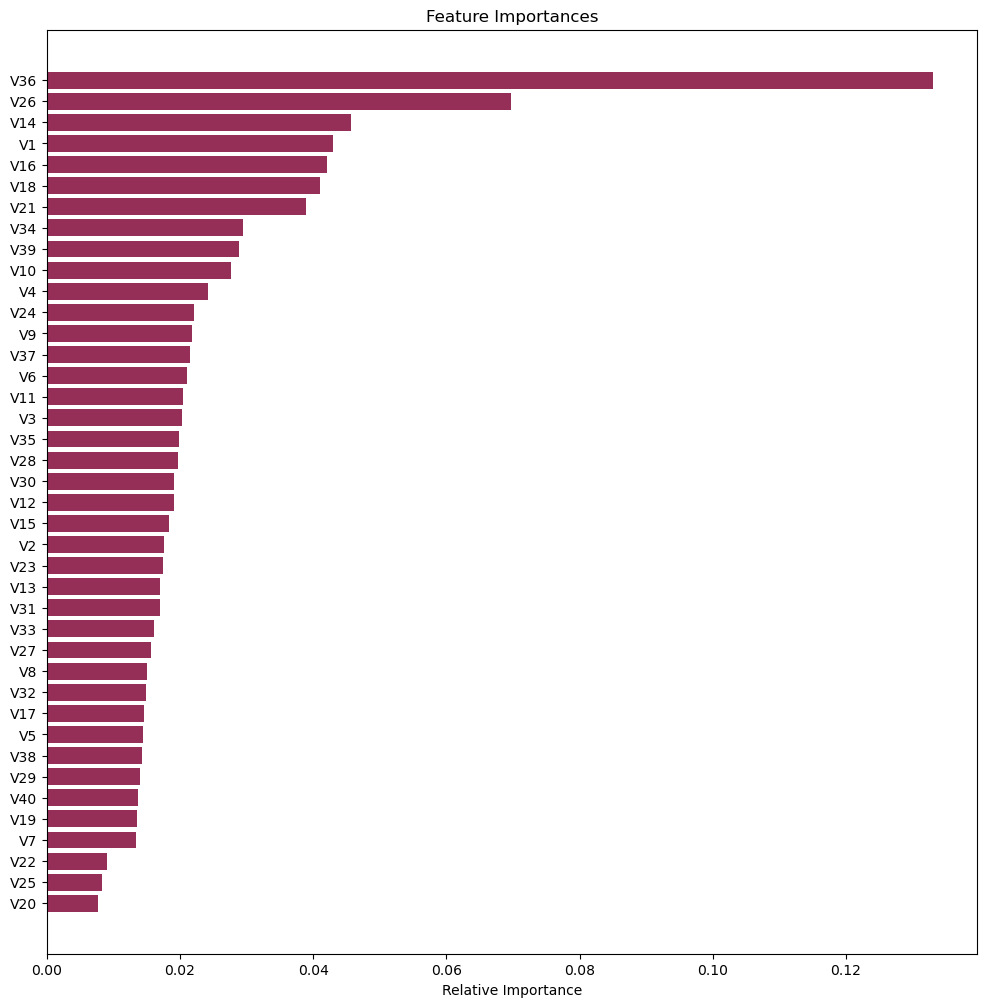

In [74]:
feature_names = X_train.columns
importances = xgb_over.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="#952f57", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Pipelines para construir el modelo final

In [68]:
# Dado que solo tenemos un tipo de datos en los datos, no necesitamos usar el transformador de columna aquí(todos son float)
Pipeline_model = Pipeline(
   steps=[
        ("imputer", SimpleImputer(strategy="median")),
        (
            "XGBoost Classifier",
             XGBClassifier(
            random_state=22,
            eval_metric="logloss",
            subsample=0.8,
            scale_pos_weight=10,
            n_estimators=250,
            learning_rate=0.1,
            gamma=0,
        )
       ),
    ]
)

In [69]:
# Separando el target
X1 = df.drop(columns="Target")
Y1 = df["Target"]

# Separando el target del test
X_test1 = df_test.drop(["Target"], axis=1)
y_test1 = df_test["Target"]

In [70]:
# Tratamiento de valores faltantes
# No es necesario hacerlo con el conjunto de pruebas porque ello se realizará en el pipeline
imputer = SimpleImputer(strategy="median")
X1 = imputer.fit_transform(X1)


In [71]:
# Aplicar el sobremuestreo
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_over1, y_over1 = sm.fit_resample(X1, Y1)

In [72]:
Pipeline_model.fit(X_over1, y_over1)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('XGBoost Classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constrain

In [73]:
# Verificar el rendimiento con el conjunto de pruebas
Pipeline_model_test = model_performance_classification_sklearn(Pipeline_model, X_test, y_test)
Pipeline_model_test

,Accuracy,Recall,Precision,F1
0,0.976,0.858,0.752,0.801


# Perspectivas y conclusiones comerciales

- El clasificador XGBoost ajustado con datos sobremuestreados tiene el mejor rendimiento.
- Precisión del modelo: La precisión del modelo es del 97.6%, lo que indica que de todas las clasificaciones que hizo el modelo, el 97.6% fueron correctas. Este es un valor muy alto, lo que sugiere que el modelo es muy bueno en la identificación general de las fallas.
- Sensibilidad (Recall): La sensibilidad del modelo es del 85.8%, lo que significa que de todas las fallas reales, el modelo pudo identificar correctamente el 85.8%. Dado que el costo de no identificar una falla es muy alto (dado que implica reemplazar el generador), sería ideal tener un valor de sensibilidad lo más cercano posible al 100%. Sin embargo, un 85.8% todavía es una tasa de detección bastante alta.
- Por último tenemos a V36 y V26 son las características más importantes. Se pueden descifrar para determinar y analizar las variables reales para comprender su impacto en la tarea predictiva en cuestión.

***